# Using physics informed neural networks (PINNs) to solve parabolic PDEs

In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from time import time
import matplotlib.pyplot as plt
import distmesh as dm
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

2022-05-05 13:34:33.005832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Class implementation of PINNs

In this section, we implement PINNs as a class which can be used for further testing. Here, we derive the class `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`.

In [86]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub, 
            output_dim=1,
            num_hidden_layers=8, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub
        
        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)
    

Next, we derive a class `PINNSolver` which can be used as a base class.
It possesses two methods to solve the PDE:
  1. the method `solve_with_TFoptimizer` uses a `TensorFlow` optimizer object as input, e.g., the `AdamOptimizer` above;
  2. the method `solve_with_LBFGS` resembles the LBFGS method proposed in the original paper using an LBFGS method provided by [`SciPy`](https://www.scipy.org/).

In [87]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)
    
    def loss_fn(self, X, u):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + u * u_x - viscosity * u_xx
    
    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    def get_upred(self, x, t):
        N = x.shape[0]
        Xgrid = np.vstack([t,x]).T
        return self.model(tf.cast(Xgrid,DTYPE)).numpy()
    
    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

## Poisson Equation

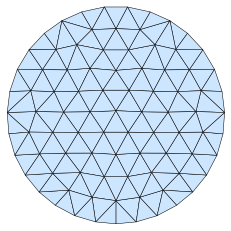

In [88]:
fd = lambda p: np.sqrt((p**2).sum(1))-1.0
p, t = dm.distmesh2d(fd, dm.huniform, 0.2, (-1,-1,1,1))

# fd=lambda p: (np.square(p[:,0])/2**2)+(np.square(p[:,1])/1**2)-1.0
# p, t= dm.distmesh2d(fd, dm.huniform,0.2,(-2,-1,2,1))

# pv = [(-0.4, -0.5), (0.4, -0.2), (0.4, -0.7), (1.5, -0.4), (0.9, 0.1), (1.6, 0.8), (0.5, 0.5), (0.2, 1), (0.1, 0.4),(-0.7, 0.7), (-0.4, -0.5)]
# fd = lambda p: dm.dpoly(p, pv)
# p, t= dm.distmesh2d(fd, dm.huniform,0.1,(-1,-1,2,1),pv)
    
e = dm.boundedges(p,t)
boundary_nodes = np.unique(e.reshape(-1))
boundary_points = p[boundary_nodes,:]
collocation_points = p[np.setxor1d(np.arange(p.shape[0], dtype=int), boundary_nodes),:]

In [97]:
# Set boundary
tmin = np.amin(p[:,1])
tmax = np.amax(p[:,1])
xmin = np.amin(p[:,0])
xmax = np.amax(p[:,0])

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

def Poisson_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def Poisson_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

In [98]:
tf.random.set_seed(0)

N_0 = boundary_points.shape[0]
N_b = boundary_points.shape[0]
N_r = p.shape[0] - N_b

# Final time data
t_0 = tf.zeros((N_0,1), dtype=DTYPE) * ub[0]
# print(t_0)
# tf.ones((N_0,1), dtype=DTYPE) * ub[0]
x_0 = tf.zeros((N_0,1), dtype=DTYPE) * ub[0]
# tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = Poisson_u_0(x_0)

# Boundary data
t_b = boundary_points[:,1].reshape(-1,1)
x_b = boundary_points[:,0].reshape(-1,1)
u_b = Poisson_u_b(t_b, x_b)
X_b = tf.concat([t_b, x_b], axis=1)

# Collocation points
X_r = tf.cast(tf.convert_to_tensor(collocation_points), tf.float32)

# Collect boundary and inital data in lists
X_data = [X_0,X_b]
u_data = [u_0,u_b]

In [99]:
class PoissonPINNSolver(PINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx, u_tt, u_xx_tt):
        """Residual of the PDE"""
        return (-1 * (u_xx+u_tt)) -1
    
    def get_r(self):
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            
            u_t = tape.gradient(u, self.t)
            u_xt = u_x + u_t
            u_xt_x = tape.gradient(u_xt, self.x)
            u_xt_t = tape.gradient(u_xt, self.t)
            u_xx_tt = u_xt_x + u_xt_t
            u_xx = tape.gradient(u_x, self.x)
            u_tt = tape.gradient(u_t, self.t)
            
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx, u_tt, u_xx_tt)

In [100]:
# Initialize model
model = PINN_NeuralNet(lb, ub, num_hidden_layers=2,
                       activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                       kernel_initializer='he_normal')
model.build(input_shape=(None,2))

# Initilize PINN solver
poissonSolver = PoissonPINNSolver(model, X_r)

In [101]:
# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-6,1e-7,1e-8])

# Solve with Adam optimizer8
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time()
poissonSolver.solve_with_TFoptimizer(optim, X_data, u_data, N=500001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.58423615e+00
It 00050: loss = 1.58200288e+00
It 00100: loss = 1.57978296e+00
It 00150: loss = 1.57758033e+00
It 00200: loss = 1.57538474e+00
It 00250: loss = 1.57319617e+00
It 00300: loss = 1.57101440e+00
It 00350: loss = 1.56883907e+00
It 00400: loss = 1.56667066e+00
It 00450: loss = 1.56451011e+00
It 00500: loss = 1.56235695e+00
It 00550: loss = 1.56021023e+00
It 00600: loss = 1.55804396e+00
It 00650: loss = 1.55587554e+00
It 00700: loss = 1.55371594e+00
It 00750: loss = 1.55156505e+00
It 00800: loss = 1.54942322e+00
It 00850: loss = 1.54729319e+00
It 00900: loss = 1.54517472e+00
It 00950: loss = 1.54306519e+00
It 01000: loss = 1.54096329e+00
It 01050: loss = 1.53886867e+00
It 01100: loss = 1.53678036e+00
It 01150: loss = 1.53469896e+00
It 01200: loss = 1.53262544e+00
It 01250: loss = 1.53055990e+00
It 01300: loss = 1.52850163e+00
It 01350: loss = 1.52645135e+00
It 01400: loss = 1.52440929e+00
It 01450: loss = 1.52237320e+00
It 01500: loss = 1.52034378e+00
It 01550

It 12850: loss = 1.44575953e+00
It 12900: loss = 1.44574881e+00
It 12950: loss = 1.44573832e+00
It 13000: loss = 1.44572759e+00
It 13050: loss = 1.44571698e+00
It 13100: loss = 1.44570613e+00
It 13150: loss = 1.44569564e+00
It 13200: loss = 1.44568491e+00
It 13250: loss = 1.44567418e+00
It 13300: loss = 1.44566345e+00
It 13350: loss = 1.44565272e+00
It 13400: loss = 1.44564223e+00
It 13450: loss = 1.44563150e+00
It 13500: loss = 1.44562078e+00
It 13550: loss = 1.44561005e+00
It 13600: loss = 1.44559944e+00
It 13650: loss = 1.44558871e+00
It 13700: loss = 1.44557810e+00
It 13750: loss = 1.44556737e+00
It 13800: loss = 1.44555688e+00
It 13850: loss = 1.44554603e+00
It 13900: loss = 1.44553530e+00
It 13950: loss = 1.44552469e+00
It 14000: loss = 1.44551396e+00
It 14050: loss = 1.44550347e+00
It 14100: loss = 1.44549251e+00
It 14150: loss = 1.44548202e+00
It 14200: loss = 1.44547129e+00
It 14250: loss = 1.44546080e+00
It 14300: loss = 1.44545007e+00
It 14350: loss = 1.44543934e+00
It 14400

It 25850: loss = 1.44298923e+00
It 25900: loss = 1.44297850e+00
It 25950: loss = 1.44296789e+00
It 26000: loss = 1.44295728e+00
It 26050: loss = 1.44294667e+00
It 26100: loss = 1.44293606e+00
It 26150: loss = 1.44292533e+00
It 26200: loss = 1.44291472e+00
It 26250: loss = 1.44290400e+00
It 26300: loss = 1.44289351e+00
It 26350: loss = 1.44288278e+00
It 26400: loss = 1.44287217e+00
It 26450: loss = 1.44286144e+00
It 26500: loss = 1.44285095e+00
It 26550: loss = 1.44284022e+00
It 26600: loss = 1.44282973e+00
It 26650: loss = 1.44281900e+00
It 26700: loss = 1.44280839e+00
It 26750: loss = 1.44279766e+00
It 26800: loss = 1.44278705e+00
It 26850: loss = 1.44277656e+00
It 26900: loss = 1.44276571e+00
It 26950: loss = 1.44275522e+00
It 27000: loss = 1.44274461e+00
It 27050: loss = 1.44273400e+00
It 27100: loss = 1.44272339e+00
It 27150: loss = 1.44271278e+00
It 27200: loss = 1.44270205e+00
It 27250: loss = 1.44269133e+00
It 27300: loss = 1.44268084e+00
It 27350: loss = 1.44267023e+00
It 27400

It 38800: loss = 1.44024110e+00
It 38850: loss = 1.44023037e+00
It 38900: loss = 1.44022000e+00
It 38950: loss = 1.44020915e+00
It 39000: loss = 1.44019866e+00
It 39050: loss = 1.44018805e+00
It 39100: loss = 1.44017756e+00
It 39150: loss = 1.44016695e+00
It 39200: loss = 1.44015622e+00
It 39250: loss = 1.44014573e+00
It 39300: loss = 1.44013524e+00
It 39350: loss = 1.44012451e+00
It 39400: loss = 1.44011402e+00
It 39450: loss = 1.44010341e+00
It 39500: loss = 1.44009280e+00
It 39550: loss = 1.44008231e+00
It 39600: loss = 1.44007158e+00
It 39650: loss = 1.44006109e+00
It 39700: loss = 1.44005036e+00
It 39750: loss = 1.44003999e+00
It 39800: loss = 1.44002938e+00
It 39850: loss = 1.44001877e+00
It 39900: loss = 1.44000816e+00
It 39950: loss = 1.43999755e+00
It 40000: loss = 1.43998694e+00
It 40050: loss = 1.43997645e+00
It 40100: loss = 1.43996584e+00
It 40150: loss = 1.43995535e+00
It 40200: loss = 1.43994462e+00
It 40250: loss = 1.43993402e+00
It 40300: loss = 1.43992352e+00
It 40350

It 51650: loss = 1.43752646e+00
It 51700: loss = 1.43751609e+00
It 51750: loss = 1.43750536e+00
It 51800: loss = 1.43749487e+00
It 51850: loss = 1.43748438e+00
It 51900: loss = 1.43747389e+00
It 51950: loss = 1.43746328e+00
It 52000: loss = 1.43745279e+00
It 52050: loss = 1.43744218e+00
It 52100: loss = 1.43743181e+00
It 52150: loss = 1.43742120e+00
It 52200: loss = 1.43741071e+00
It 52250: loss = 1.43739998e+00
It 52300: loss = 1.43738961e+00
It 52350: loss = 1.43737900e+00
It 52400: loss = 1.43736851e+00
It 52450: loss = 1.43735790e+00
It 52500: loss = 1.43734741e+00
It 52550: loss = 1.43733692e+00
It 52600: loss = 1.43732643e+00
It 52650: loss = 1.43731582e+00
It 52700: loss = 1.43730545e+00
It 52750: loss = 1.43729472e+00
It 52800: loss = 1.43728423e+00
It 52850: loss = 1.43727374e+00
It 52900: loss = 1.43726325e+00
It 52950: loss = 1.43725264e+00
It 53000: loss = 1.43724203e+00
It 53050: loss = 1.43723154e+00
It 53100: loss = 1.43722105e+00
It 53150: loss = 1.43721056e+00
It 53200

It 64650: loss = 1.43479443e+00
It 64700: loss = 1.43478394e+00
It 64750: loss = 1.43477345e+00
It 64800: loss = 1.43476284e+00
It 64850: loss = 1.43475246e+00
It 64900: loss = 1.43474197e+00
It 64950: loss = 1.43473148e+00
It 65000: loss = 1.43472111e+00
It 65050: loss = 1.43471050e+00
It 65100: loss = 1.43470013e+00
It 65150: loss = 1.43468964e+00
It 65200: loss = 1.43467915e+00
It 65250: loss = 1.43466866e+00
It 65300: loss = 1.43465817e+00
It 65350: loss = 1.43464768e+00
It 65400: loss = 1.43463719e+00
It 65450: loss = 1.43462670e+00
It 65500: loss = 1.43461633e+00
It 65550: loss = 1.43460572e+00
It 65600: loss = 1.43459535e+00
It 65650: loss = 1.43458486e+00
It 65700: loss = 1.43457448e+00
It 65750: loss = 1.43456388e+00
It 65800: loss = 1.43455338e+00
It 65850: loss = 1.43454289e+00
It 65900: loss = 1.43453252e+00
It 65950: loss = 1.43452203e+00
It 66000: loss = 1.43451166e+00
It 66050: loss = 1.43450105e+00
It 66100: loss = 1.43449068e+00
It 66150: loss = 1.43448019e+00
It 66200

It 77600: loss = 1.43209410e+00
It 77650: loss = 1.43208385e+00
It 77700: loss = 1.43207335e+00
It 77750: loss = 1.43206298e+00
It 77800: loss = 1.43205261e+00
It 77850: loss = 1.43204212e+00
It 77900: loss = 1.43203187e+00
It 77950: loss = 1.43202138e+00
It 78000: loss = 1.43201113e+00
It 78050: loss = 1.43200064e+00
It 78100: loss = 1.43199039e+00
It 78150: loss = 1.43197989e+00
It 78200: loss = 1.43196940e+00
It 78250: loss = 1.43195903e+00
It 78300: loss = 1.43194878e+00
It 78350: loss = 1.43193829e+00
It 78400: loss = 1.43192804e+00
It 78450: loss = 1.43191743e+00
It 78500: loss = 1.43190718e+00
It 78550: loss = 1.43189681e+00
It 78600: loss = 1.43188643e+00
It 78650: loss = 1.43187606e+00
It 78700: loss = 1.43186569e+00
It 78750: loss = 1.43185520e+00
It 78800: loss = 1.43184483e+00
It 78850: loss = 1.43183446e+00
It 78900: loss = 1.43182409e+00
It 78950: loss = 1.43181372e+00
It 79000: loss = 1.43180346e+00
It 79050: loss = 1.43179297e+00
It 79100: loss = 1.43178260e+00
It 79150

It 90600: loss = 1.42939925e+00
It 90650: loss = 1.42938876e+00
It 90700: loss = 1.42937851e+00
It 90750: loss = 1.42936802e+00
It 90800: loss = 1.42935777e+00
It 90850: loss = 1.42934752e+00
It 90900: loss = 1.42933714e+00
It 90950: loss = 1.42932677e+00
It 91000: loss = 1.42931628e+00
It 91050: loss = 1.42930615e+00
It 91100: loss = 1.42929566e+00
It 91150: loss = 1.42928553e+00
It 91200: loss = 1.42927504e+00
It 91250: loss = 1.42926478e+00
It 91300: loss = 1.42925429e+00
It 91350: loss = 1.42924404e+00
It 91400: loss = 1.42923367e+00
It 91450: loss = 1.42922342e+00
It 91500: loss = 1.42921305e+00
It 91550: loss = 1.42920268e+00
It 91600: loss = 1.42919242e+00
It 91650: loss = 1.42918205e+00
It 91700: loss = 1.42917180e+00
It 91750: loss = 1.42916131e+00
It 91800: loss = 1.42915106e+00
It 91850: loss = 1.42914069e+00
It 91900: loss = 1.42913043e+00
It 91950: loss = 1.42912006e+00
It 92000: loss = 1.42910969e+00
It 92050: loss = 1.42909932e+00
It 92100: loss = 1.42908907e+00
It 92150

It 103600: loss = 1.42672515e+00
It 103650: loss = 1.42671490e+00
It 103700: loss = 1.42670465e+00
It 103750: loss = 1.42669439e+00
It 103800: loss = 1.42668414e+00
It 103850: loss = 1.42667377e+00
It 103900: loss = 1.42666364e+00
It 103950: loss = 1.42665327e+00
It 104000: loss = 1.42664313e+00
It 104050: loss = 1.42663276e+00
It 104100: loss = 1.42662263e+00
It 104150: loss = 1.42661238e+00
It 104200: loss = 1.42660213e+00
It 104250: loss = 1.42659187e+00
It 104300: loss = 1.42658162e+00
It 104350: loss = 1.42657137e+00
It 104400: loss = 1.42656100e+00
It 104450: loss = 1.42655087e+00
It 104500: loss = 1.42654049e+00
It 104550: loss = 1.42653036e+00
It 104600: loss = 1.42651999e+00
It 104650: loss = 1.42650986e+00
It 104700: loss = 1.42649961e+00
It 104750: loss = 1.42648935e+00
It 104800: loss = 1.42647910e+00
It 104850: loss = 1.42646873e+00
It 104900: loss = 1.42645848e+00
It 104950: loss = 1.42644811e+00
It 105000: loss = 1.42643809e+00
It 105050: loss = 1.42642784e+00
It 105100:

It 116050: loss = 1.42417586e+00
It 116100: loss = 1.42416573e+00
It 116150: loss = 1.42415547e+00
It 116200: loss = 1.42414522e+00
It 116250: loss = 1.42413497e+00
It 116300: loss = 1.42412472e+00
It 116350: loss = 1.42411458e+00
It 116400: loss = 1.42410445e+00
It 116450: loss = 1.42409420e+00
It 116500: loss = 1.42408395e+00
It 116550: loss = 1.42407382e+00
It 116600: loss = 1.42406356e+00
It 116650: loss = 1.42405319e+00
It 116700: loss = 1.42404306e+00
It 116750: loss = 1.42403281e+00
It 116800: loss = 1.42402267e+00
It 116850: loss = 1.42401242e+00
It 116900: loss = 1.42400217e+00
It 116950: loss = 1.42399204e+00
It 117000: loss = 1.42398179e+00
It 117050: loss = 1.42397165e+00
It 117100: loss = 1.42396128e+00
It 117150: loss = 1.42395115e+00
It 117200: loss = 1.42394078e+00
It 117250: loss = 1.42393076e+00
It 117300: loss = 1.42392051e+00
It 117350: loss = 1.42391026e+00
It 117400: loss = 1.42390013e+00
It 117450: loss = 1.42388988e+00
It 117500: loss = 1.42387974e+00
It 117550:

It 128550: loss = 1.42162681e+00
It 128600: loss = 1.42161667e+00
It 128650: loss = 1.42160642e+00
It 128700: loss = 1.42159629e+00
It 128750: loss = 1.42158616e+00
It 128800: loss = 1.42157602e+00
It 128850: loss = 1.42156589e+00
It 128900: loss = 1.42155564e+00
It 128950: loss = 1.42154551e+00
It 129000: loss = 1.42153525e+00
It 129050: loss = 1.42152512e+00
It 129100: loss = 1.42151487e+00
It 129150: loss = 1.42150462e+00
It 129200: loss = 1.42149460e+00
It 129250: loss = 1.42148435e+00
It 129300: loss = 1.42147434e+00
It 129350: loss = 1.42146397e+00
It 129400: loss = 1.42145395e+00
It 129450: loss = 1.42144358e+00
It 129500: loss = 1.42143345e+00
It 129550: loss = 1.42142344e+00
It 129600: loss = 1.42141318e+00
It 129650: loss = 1.42140293e+00
It 129700: loss = 1.42139268e+00
It 129750: loss = 1.42138267e+00
It 129800: loss = 1.42137265e+00
It 129850: loss = 1.42136240e+00
It 129900: loss = 1.42135215e+00
It 129950: loss = 1.42134190e+00
It 130000: loss = 1.42133176e+00
It 130050:

It 141350: loss = 1.41902745e+00
It 141400: loss = 1.41901731e+00
It 141450: loss = 1.41900718e+00
It 141500: loss = 1.41899693e+00
It 141550: loss = 1.41898704e+00
It 141600: loss = 1.41897690e+00
It 141650: loss = 1.41896665e+00
It 141700: loss = 1.41895664e+00
It 141750: loss = 1.41894627e+00
It 141800: loss = 1.41893625e+00
It 141850: loss = 1.41892612e+00
It 141900: loss = 1.41891599e+00
It 141950: loss = 1.41890585e+00
It 142000: loss = 1.41889572e+00
It 142050: loss = 1.41888571e+00
It 142100: loss = 1.41887569e+00
It 142150: loss = 1.41886544e+00
It 142200: loss = 1.41885531e+00
It 142250: loss = 1.41884506e+00
It 142300: loss = 1.41883492e+00
It 142350: loss = 1.41882491e+00
It 142400: loss = 1.41881466e+00
It 142450: loss = 1.41880465e+00
It 142500: loss = 1.41879439e+00
It 142550: loss = 1.41878438e+00
It 142600: loss = 1.41877425e+00
It 142650: loss = 1.41876411e+00
It 142700: loss = 1.41875398e+00
It 142750: loss = 1.41874385e+00
It 142800: loss = 1.41873360e+00
It 142850:

It 153800: loss = 1.41650939e+00
It 153850: loss = 1.41649938e+00
It 153900: loss = 1.41648936e+00
It 153950: loss = 1.41647911e+00
It 154000: loss = 1.41646910e+00
It 154050: loss = 1.41645908e+00
It 154100: loss = 1.41644883e+00
It 154150: loss = 1.41643870e+00
It 154200: loss = 1.41642857e+00
It 154250: loss = 1.41641855e+00
It 154300: loss = 1.41640842e+00
It 154350: loss = 1.41639829e+00
It 154400: loss = 1.41638827e+00
It 154450: loss = 1.41637802e+00
It 154500: loss = 1.41636801e+00
It 154550: loss = 1.41635787e+00
It 154600: loss = 1.41634774e+00
It 154650: loss = 1.41633761e+00
It 154700: loss = 1.41632748e+00
It 154750: loss = 1.41631746e+00
It 154800: loss = 1.41630745e+00
It 154850: loss = 1.41629720e+00
It 154900: loss = 1.41628718e+00
It 154950: loss = 1.41627717e+00
It 155000: loss = 1.41626692e+00
It 155050: loss = 1.41625679e+00
It 155100: loss = 1.41624665e+00
It 155150: loss = 1.41623664e+00
It 155200: loss = 1.41622663e+00
It 155250: loss = 1.41621637e+00
It 155300:

It 166350: loss = 1.41397548e+00
It 166400: loss = 1.41396546e+00
It 166450: loss = 1.41395521e+00
It 166500: loss = 1.41394520e+00
It 166550: loss = 1.41393507e+00
It 166600: loss = 1.41392505e+00
It 166650: loss = 1.41391504e+00
It 166700: loss = 1.41390491e+00
It 166750: loss = 1.41389489e+00
It 166800: loss = 1.41388476e+00
It 166850: loss = 1.41387463e+00
It 166900: loss = 1.41386461e+00
It 166950: loss = 1.41385436e+00
It 167000: loss = 1.41384435e+00
It 167050: loss = 1.41383433e+00
It 167100: loss = 1.41382432e+00
It 167150: loss = 1.41381419e+00
It 167200: loss = 1.41380417e+00
It 167250: loss = 1.41379404e+00
It 167300: loss = 1.41378403e+00
It 167350: loss = 1.41377389e+00
It 167400: loss = 1.41376376e+00
It 167450: loss = 1.41375375e+00
It 167500: loss = 1.41374350e+00
It 167550: loss = 1.41373360e+00
It 167600: loss = 1.41372359e+00
It 167650: loss = 1.41371346e+00
It 167700: loss = 1.41370344e+00
It 167750: loss = 1.41369343e+00
It 167800: loss = 1.41368318e+00
It 167850:

It 178850: loss = 1.41146040e+00
It 178900: loss = 1.41145027e+00
It 178950: loss = 1.41144037e+00
It 179000: loss = 1.41143024e+00
It 179050: loss = 1.41142023e+00
It 179100: loss = 1.41141009e+00
It 179150: loss = 1.41140020e+00
It 179200: loss = 1.41139030e+00
It 179250: loss = 1.41138005e+00
It 179300: loss = 1.41137004e+00
It 179350: loss = 1.41136003e+00
It 179400: loss = 1.41135001e+00
It 179450: loss = 1.41134000e+00
It 179500: loss = 1.41132987e+00
It 179550: loss = 1.41131997e+00
It 179600: loss = 1.41130984e+00
It 179650: loss = 1.41129971e+00
It 179700: loss = 1.41128969e+00
It 179750: loss = 1.41127968e+00
It 179800: loss = 1.41126966e+00
It 179850: loss = 1.41125953e+00
It 179900: loss = 1.41124964e+00
It 179950: loss = 1.41123962e+00
It 180000: loss = 1.41122961e+00
It 180050: loss = 1.41121948e+00
It 180100: loss = 1.41120934e+00
It 180150: loss = 1.41119945e+00
It 180200: loss = 1.41118932e+00
It 180250: loss = 1.41117930e+00
It 180300: loss = 1.41116929e+00
It 180350:

It 191350: loss = 1.40895534e+00
It 191400: loss = 1.40894532e+00
It 191450: loss = 1.40893531e+00
It 191500: loss = 1.40892529e+00
It 191550: loss = 1.40891528e+00
It 191600: loss = 1.40890539e+00
It 191650: loss = 1.40889525e+00
It 191700: loss = 1.40888524e+00
It 191750: loss = 1.40887535e+00
It 191800: loss = 1.40886533e+00
It 191850: loss = 1.40885544e+00
It 191900: loss = 1.40884542e+00
It 191950: loss = 1.40883529e+00
It 192000: loss = 1.40882540e+00
It 192050: loss = 1.40881526e+00
It 192100: loss = 1.40880537e+00
It 192150: loss = 1.40879536e+00
It 192200: loss = 1.40878534e+00
It 192250: loss = 1.40877545e+00
It 192300: loss = 1.40876532e+00
It 192350: loss = 1.40875542e+00
It 192400: loss = 1.40874529e+00
It 192450: loss = 1.40873539e+00
It 192500: loss = 1.40872538e+00
It 192550: loss = 1.40871525e+00
It 192600: loss = 1.40870535e+00
It 192650: loss = 1.40869534e+00
It 192700: loss = 1.40868533e+00
It 192750: loss = 1.40867543e+00
It 192800: loss = 1.40866542e+00
It 192850:

It 203850: loss = 1.40646029e+00
It 203900: loss = 1.40645051e+00
It 203950: loss = 1.40644050e+00
It 204000: loss = 1.40643048e+00
It 204050: loss = 1.40642071e+00
It 204100: loss = 1.40641069e+00
It 204150: loss = 1.40640068e+00
It 204200: loss = 1.40639091e+00
It 204250: loss = 1.40638065e+00
It 204300: loss = 1.40637088e+00
It 204350: loss = 1.40636086e+00
It 204400: loss = 1.40635085e+00
It 204450: loss = 1.40634108e+00
It 204500: loss = 1.40633106e+00
It 204550: loss = 1.40632105e+00
It 204600: loss = 1.40631115e+00
It 204650: loss = 1.40630126e+00
It 204700: loss = 1.40629125e+00
It 204750: loss = 1.40628123e+00
It 204800: loss = 1.40627122e+00
It 204850: loss = 1.40626121e+00
It 204900: loss = 1.40625143e+00
It 204950: loss = 1.40624142e+00
It 205000: loss = 1.40623152e+00
It 205050: loss = 1.40622163e+00
It 205100: loss = 1.40621161e+00
It 205150: loss = 1.40620160e+00
It 205200: loss = 1.40619159e+00
It 205250: loss = 1.40618169e+00
It 205300: loss = 1.40617180e+00
It 205350:

It 216750: loss = 1.40389705e+00
It 216800: loss = 1.40388715e+00
It 216850: loss = 1.40387726e+00
It 216900: loss = 1.40386736e+00
It 216950: loss = 1.40385747e+00
It 217000: loss = 1.40384746e+00
It 217050: loss = 1.40383756e+00
It 217100: loss = 1.40382767e+00
It 217150: loss = 1.40381765e+00
It 217200: loss = 1.40380788e+00
It 217250: loss = 1.40379798e+00
It 217300: loss = 1.40378797e+00
It 217350: loss = 1.40377808e+00
It 217400: loss = 1.40376830e+00
It 217450: loss = 1.40375829e+00
It 217500: loss = 1.40374851e+00
It 217550: loss = 1.40373862e+00
It 217600: loss = 1.40372860e+00
It 217650: loss = 1.40371871e+00
It 217700: loss = 1.40370870e+00
It 217750: loss = 1.40369880e+00
It 217800: loss = 1.40368891e+00
It 217850: loss = 1.40367901e+00
It 217900: loss = 1.40366912e+00
It 217950: loss = 1.40365934e+00
It 218000: loss = 1.40364933e+00
It 218050: loss = 1.40363944e+00
It 218100: loss = 1.40362954e+00
It 218150: loss = 1.40361953e+00
It 218200: loss = 1.40360963e+00
It 218250:

It 229250: loss = 1.40142477e+00
It 229300: loss = 1.40141487e+00
It 229350: loss = 1.40140498e+00
It 229400: loss = 1.40139520e+00
It 229450: loss = 1.40138531e+00
It 229500: loss = 1.40137553e+00
It 229550: loss = 1.40136576e+00
It 229600: loss = 1.40135574e+00
It 229650: loss = 1.40134597e+00
It 229700: loss = 1.40133619e+00
It 229750: loss = 1.40132642e+00
It 229800: loss = 1.40131652e+00
It 229850: loss = 1.40130663e+00
It 229900: loss = 1.40129685e+00
It 229950: loss = 1.40128696e+00
It 230000: loss = 1.40127707e+00
It 230050: loss = 1.40126741e+00
It 230100: loss = 1.40125751e+00
It 230150: loss = 1.40124774e+00
It 230200: loss = 1.40123796e+00
It 230250: loss = 1.40122819e+00
It 230300: loss = 1.40121830e+00
It 230350: loss = 1.40120852e+00
It 230400: loss = 1.40119863e+00
It 230450: loss = 1.40118873e+00
It 230500: loss = 1.40117896e+00
It 230550: loss = 1.40116918e+00
It 230600: loss = 1.40115929e+00
It 230650: loss = 1.40114951e+00
It 230700: loss = 1.40113974e+00
It 230750:

It 241700: loss = 1.39898181e+00
It 241750: loss = 1.39897192e+00
It 241800: loss = 1.39896226e+00
It 241850: loss = 1.39895248e+00
It 241900: loss = 1.39894259e+00
It 241950: loss = 1.39893293e+00
It 242000: loss = 1.39892304e+00
It 242050: loss = 1.39891338e+00
It 242100: loss = 1.39890361e+00
It 242150: loss = 1.39889371e+00
It 242200: loss = 1.39888382e+00
It 242250: loss = 1.39887416e+00
It 242300: loss = 1.39886427e+00
It 242350: loss = 1.39885449e+00
It 242400: loss = 1.39884472e+00
It 242450: loss = 1.39883494e+00
It 242500: loss = 1.39882529e+00
It 242550: loss = 1.39881551e+00
It 242600: loss = 1.39880562e+00
It 242650: loss = 1.39879584e+00
It 242700: loss = 1.39878607e+00
It 242750: loss = 1.39877629e+00
It 242800: loss = 1.39876640e+00
It 242850: loss = 1.39875674e+00
It 242900: loss = 1.39874697e+00
It 242950: loss = 1.39873707e+00
It 243000: loss = 1.39872742e+00
It 243050: loss = 1.39871764e+00
It 243100: loss = 1.39870775e+00
It 243150: loss = 1.39869797e+00
It 243200:

It 254150: loss = 1.39654911e+00
It 254200: loss = 1.39653921e+00
It 254250: loss = 1.39652967e+00
It 254300: loss = 1.39651978e+00
It 254350: loss = 1.39651012e+00
It 254400: loss = 1.39650047e+00
It 254450: loss = 1.39649057e+00
It 254500: loss = 1.39648080e+00
It 254550: loss = 1.39647102e+00
It 254600: loss = 1.39646125e+00
It 254650: loss = 1.39645159e+00
It 254700: loss = 1.39644182e+00
It 254750: loss = 1.39643216e+00
It 254800: loss = 1.39642251e+00
It 254850: loss = 1.39641261e+00
It 254900: loss = 1.39640296e+00
It 254950: loss = 1.39639306e+00
It 255000: loss = 1.39638340e+00
It 255050: loss = 1.39637363e+00
It 255100: loss = 1.39636374e+00
It 255150: loss = 1.39635420e+00
It 255200: loss = 1.39634430e+00
It 255250: loss = 1.39633477e+00
It 255300: loss = 1.39632487e+00
It 255350: loss = 1.39631522e+00
It 255400: loss = 1.39630556e+00
It 255450: loss = 1.39629555e+00
It 255500: loss = 1.39628589e+00
It 255550: loss = 1.39627612e+00
It 255600: loss = 1.39626646e+00
It 255650:

It 266650: loss = 1.39411640e+00
It 266700: loss = 1.39410686e+00
It 266750: loss = 1.39409697e+00
It 266800: loss = 1.39408731e+00
It 266850: loss = 1.39407766e+00
It 266900: loss = 1.39406776e+00
It 266950: loss = 1.39405823e+00
It 267000: loss = 1.39404833e+00
It 267050: loss = 1.39403880e+00
It 267100: loss = 1.39402914e+00
It 267150: loss = 1.39401937e+00
It 267200: loss = 1.39400971e+00
It 267250: loss = 1.39399993e+00
It 267300: loss = 1.39399016e+00
It 267350: loss = 1.39398050e+00
It 267400: loss = 1.39397073e+00
It 267450: loss = 1.39396119e+00
It 267500: loss = 1.39395142e+00
It 267550: loss = 1.39394164e+00
It 267600: loss = 1.39393198e+00
It 267650: loss = 1.39392233e+00
It 267700: loss = 1.39391255e+00
It 267750: loss = 1.39390290e+00
It 267800: loss = 1.39389300e+00
It 267850: loss = 1.39388347e+00
It 267900: loss = 1.39387369e+00
It 267950: loss = 1.39386392e+00
It 268000: loss = 1.39385426e+00
It 268050: loss = 1.39384460e+00
It 268100: loss = 1.39383495e+00
It 268150:

It 279150: loss = 1.39169347e+00
It 279200: loss = 1.39168394e+00
It 279250: loss = 1.39167428e+00
It 279300: loss = 1.39166462e+00
It 279350: loss = 1.39165497e+00
It 279400: loss = 1.39164531e+00
It 279450: loss = 1.39163566e+00
It 279500: loss = 1.39162588e+00
It 279550: loss = 1.39161623e+00
It 279600: loss = 1.39160657e+00
It 279650: loss = 1.39159679e+00
It 279700: loss = 1.39158726e+00
It 279750: loss = 1.39157760e+00
It 279800: loss = 1.39156795e+00
It 279850: loss = 1.39155829e+00
It 279900: loss = 1.39154863e+00
It 279950: loss = 1.39153898e+00
It 280000: loss = 1.39152932e+00
It 280050: loss = 1.39151943e+00
It 280100: loss = 1.39150989e+00
It 280150: loss = 1.39150023e+00
It 280200: loss = 1.39149046e+00
It 280250: loss = 1.39148080e+00
It 280300: loss = 1.39147127e+00
It 280350: loss = 1.39146161e+00
It 280400: loss = 1.39145207e+00
It 280450: loss = 1.39144230e+00
It 280500: loss = 1.39143252e+00
It 280550: loss = 1.39142299e+00
It 280600: loss = 1.39141321e+00
It 280650:

It 291650: loss = 1.38928056e+00
It 291700: loss = 1.38927114e+00
It 291750: loss = 1.38926136e+00
It 291800: loss = 1.38925171e+00
It 291850: loss = 1.38924217e+00
It 291900: loss = 1.38923240e+00
It 291950: loss = 1.38922286e+00
It 292000: loss = 1.38921309e+00
It 292050: loss = 1.38920355e+00
It 292100: loss = 1.38919389e+00
It 292150: loss = 1.38918424e+00
It 292200: loss = 1.38917470e+00
It 292250: loss = 1.38916516e+00
It 292300: loss = 1.38915539e+00
It 292350: loss = 1.38914585e+00
It 292400: loss = 1.38913620e+00
It 292450: loss = 1.38912654e+00
It 292500: loss = 1.38911688e+00
It 292550: loss = 1.38910735e+00
It 292600: loss = 1.38909757e+00
It 292650: loss = 1.38908803e+00
It 292700: loss = 1.38907850e+00
It 292750: loss = 1.38906872e+00
It 292800: loss = 1.38905919e+00
It 292850: loss = 1.38904941e+00
It 292900: loss = 1.38903975e+00
It 292950: loss = 1.38903022e+00
It 293000: loss = 1.38902044e+00
It 293050: loss = 1.38901091e+00
It 293100: loss = 1.38900137e+00
It 293150:

It 304150: loss = 1.38687611e+00
It 304200: loss = 1.38686657e+00
It 304250: loss = 1.38685691e+00
It 304300: loss = 1.38684738e+00
It 304350: loss = 1.38683772e+00
It 304400: loss = 1.38682818e+00
It 304450: loss = 1.38681865e+00
It 304500: loss = 1.38680887e+00
It 304550: loss = 1.38679945e+00
It 304600: loss = 1.38678992e+00
It 304650: loss = 1.38678014e+00
It 304700: loss = 1.38677049e+00
It 304750: loss = 1.38676095e+00
It 304800: loss = 1.38675117e+00
It 304850: loss = 1.38674176e+00
It 304900: loss = 1.38673210e+00
It 304950: loss = 1.38672256e+00
It 305000: loss = 1.38671303e+00
It 305050: loss = 1.38670349e+00
It 305100: loss = 1.38669372e+00
It 305150: loss = 1.38668418e+00
It 305200: loss = 1.38667464e+00
It 305250: loss = 1.38666487e+00
It 305300: loss = 1.38665533e+00
It 305350: loss = 1.38664579e+00
It 305400: loss = 1.38663602e+00
It 305450: loss = 1.38662648e+00
It 305500: loss = 1.38661706e+00
It 305550: loss = 1.38660741e+00
It 305600: loss = 1.38659787e+00
It 305650:

It 316650: loss = 1.38448071e+00
It 316700: loss = 1.38447106e+00
It 316750: loss = 1.38446152e+00
It 316800: loss = 1.38445199e+00
It 316850: loss = 1.38444245e+00
It 316900: loss = 1.38443291e+00
It 316950: loss = 1.38442338e+00
It 317000: loss = 1.38441372e+00
It 317050: loss = 1.38440418e+00
It 317100: loss = 1.38439465e+00
It 317150: loss = 1.38438499e+00
It 317200: loss = 1.38437557e+00
It 317250: loss = 1.38436604e+00
It 317300: loss = 1.38435638e+00
It 317350: loss = 1.38434684e+00
It 317400: loss = 1.38433731e+00
It 317450: loss = 1.38432765e+00
It 317500: loss = 1.38431811e+00
It 317550: loss = 1.38430858e+00
It 317600: loss = 1.38429892e+00
It 317650: loss = 1.38428938e+00
It 317700: loss = 1.38427985e+00
It 317750: loss = 1.38427019e+00
It 317800: loss = 1.38426077e+00
It 317850: loss = 1.38425124e+00
It 317900: loss = 1.38424158e+00
It 317950: loss = 1.38423204e+00
It 318000: loss = 1.38422251e+00
It 318050: loss = 1.38421297e+00
It 318100: loss = 1.38420343e+00
It 318150:

It 329150: loss = 1.38209498e+00
It 329200: loss = 1.38208556e+00
It 329250: loss = 1.38207603e+00
It 329300: loss = 1.38206649e+00
It 329350: loss = 1.38205695e+00
It 329400: loss = 1.38204741e+00
It 329450: loss = 1.38203788e+00
It 329500: loss = 1.38202846e+00
It 329550: loss = 1.38201892e+00
It 329600: loss = 1.38200939e+00
It 329650: loss = 1.38199985e+00
It 329700: loss = 1.38199043e+00
It 329750: loss = 1.38198090e+00
It 329800: loss = 1.38197136e+00
It 329850: loss = 1.38196182e+00
It 329900: loss = 1.38195240e+00
It 329950: loss = 1.38194275e+00
It 330000: loss = 1.38193333e+00
It 330050: loss = 1.38192391e+00
It 330100: loss = 1.38191426e+00
It 330150: loss = 1.38190484e+00
It 330200: loss = 1.38189530e+00
It 330250: loss = 1.38188577e+00
It 330300: loss = 1.38187611e+00
It 330350: loss = 1.38186669e+00
It 330400: loss = 1.38185716e+00
It 330450: loss = 1.38184762e+00
It 330500: loss = 1.38183820e+00
It 330550: loss = 1.38182855e+00
It 330600: loss = 1.38181913e+00
It 330650:

It 341650: loss = 1.37972140e+00
It 341700: loss = 1.37971187e+00
It 341750: loss = 1.37970233e+00
It 341800: loss = 1.37969291e+00
It 341850: loss = 1.37968349e+00
It 341900: loss = 1.37967396e+00
It 341950: loss = 1.37966454e+00
It 342000: loss = 1.37965500e+00
It 342050: loss = 1.37964571e+00
It 342100: loss = 1.37963605e+00
It 342150: loss = 1.37962663e+00
It 342200: loss = 1.37961721e+00
It 342250: loss = 1.37960756e+00
It 342300: loss = 1.37959814e+00
It 342350: loss = 1.37958872e+00
It 342400: loss = 1.37957931e+00
It 342450: loss = 1.37956977e+00
It 342500: loss = 1.37956035e+00
It 342550: loss = 1.37955070e+00
It 342600: loss = 1.37954128e+00
It 342650: loss = 1.37953186e+00
It 342700: loss = 1.37952244e+00
It 342750: loss = 1.37951291e+00
It 342800: loss = 1.37950349e+00
It 342850: loss = 1.37949407e+00
It 342900: loss = 1.37948453e+00
It 342950: loss = 1.37947512e+00
It 343000: loss = 1.37946570e+00
It 343050: loss = 1.37945604e+00
It 343100: loss = 1.37944663e+00
It 343150:

It 354100: loss = 1.37736702e+00
It 354150: loss = 1.37735748e+00
It 354200: loss = 1.37734807e+00
It 354250: loss = 1.37733865e+00
It 354300: loss = 1.37732923e+00
It 354350: loss = 1.37731981e+00
It 354400: loss = 1.37731028e+00
It 354450: loss = 1.37730098e+00
It 354500: loss = 1.37729144e+00
It 354550: loss = 1.37728202e+00
It 354600: loss = 1.37727273e+00
It 354650: loss = 1.37726319e+00
It 354700: loss = 1.37725365e+00
It 354750: loss = 1.37724435e+00
It 354800: loss = 1.37723494e+00
It 354850: loss = 1.37722540e+00
It 354900: loss = 1.37721598e+00
It 354950: loss = 1.37720656e+00
It 355000: loss = 1.37719715e+00
It 355050: loss = 1.37718761e+00
It 355100: loss = 1.37717831e+00
It 355150: loss = 1.37716889e+00
It 355200: loss = 1.37715936e+00
It 355250: loss = 1.37715006e+00
It 355300: loss = 1.37714064e+00
It 355350: loss = 1.37713122e+00
It 355400: loss = 1.37712169e+00
It 355450: loss = 1.37711227e+00
It 355500: loss = 1.37710285e+00
It 355550: loss = 1.37709332e+00
It 355600:

It 366600: loss = 1.37501299e+00
It 366650: loss = 1.37500370e+00
It 366700: loss = 1.37499416e+00
It 366750: loss = 1.37498486e+00
It 366800: loss = 1.37497544e+00
It 366850: loss = 1.37496603e+00
It 366900: loss = 1.37495661e+00
It 366950: loss = 1.37494707e+00
It 367000: loss = 1.37493777e+00
It 367050: loss = 1.37492847e+00
It 367100: loss = 1.37491918e+00
It 367150: loss = 1.37490964e+00
It 367200: loss = 1.37490034e+00
It 367250: loss = 1.37489092e+00
It 367300: loss = 1.37488139e+00
It 367350: loss = 1.37487209e+00
It 367400: loss = 1.37486267e+00
It 367450: loss = 1.37485337e+00
It 367500: loss = 1.37484384e+00
It 367550: loss = 1.37483454e+00
It 367600: loss = 1.37482524e+00
It 367650: loss = 1.37481570e+00
It 367700: loss = 1.37480640e+00
It 367750: loss = 1.37479699e+00
It 367800: loss = 1.37478757e+00
It 367850: loss = 1.37477815e+00
It 367900: loss = 1.37476873e+00
It 367950: loss = 1.37475944e+00
It 368000: loss = 1.37475002e+00
It 368050: loss = 1.37474060e+00
It 368100:

It 379100: loss = 1.37266922e+00
It 379150: loss = 1.37265992e+00
It 379200: loss = 1.37265050e+00
It 379250: loss = 1.37264109e+00
It 379300: loss = 1.37263179e+00
It 379350: loss = 1.37262249e+00
It 379400: loss = 1.37261307e+00
It 379450: loss = 1.37260377e+00
It 379500: loss = 1.37259436e+00
It 379550: loss = 1.37258494e+00
It 379600: loss = 1.37257552e+00
It 379650: loss = 1.37256622e+00
It 379700: loss = 1.37255692e+00
It 379750: loss = 1.37254763e+00
It 379800: loss = 1.37253833e+00
It 379850: loss = 1.37252891e+00
It 379900: loss = 1.37251949e+00
It 379950: loss = 1.37251019e+00
It 380000: loss = 1.37250090e+00
It 380050: loss = 1.37249148e+00
It 380100: loss = 1.37248206e+00
It 380150: loss = 1.37247276e+00
It 380200: loss = 1.37246346e+00
It 380250: loss = 1.37245417e+00
It 380300: loss = 1.37244463e+00
It 380350: loss = 1.37243545e+00
It 380400: loss = 1.37242603e+00
It 380450: loss = 1.37241673e+00
It 380500: loss = 1.37240732e+00
It 380550: loss = 1.37239790e+00
It 380600:

It 391600: loss = 1.37033439e+00
It 391650: loss = 1.37032509e+00
It 391700: loss = 1.37031579e+00
It 391750: loss = 1.37030637e+00
It 391800: loss = 1.37029707e+00
It 391850: loss = 1.37028766e+00
It 391900: loss = 1.37027836e+00
It 391950: loss = 1.37026906e+00
It 392000: loss = 1.37025976e+00
It 392050: loss = 1.37025034e+00
It 392100: loss = 1.37024105e+00
It 392150: loss = 1.37023187e+00
It 392200: loss = 1.37022245e+00
It 392250: loss = 1.37021327e+00
It 392300: loss = 1.37020385e+00
It 392350: loss = 1.37019444e+00
It 392400: loss = 1.37018514e+00
It 392450: loss = 1.37017584e+00
It 392500: loss = 1.37016654e+00
It 392550: loss = 1.37015724e+00
It 392600: loss = 1.37014794e+00
It 392650: loss = 1.37013865e+00
It 392700: loss = 1.37012923e+00
It 392750: loss = 1.37011993e+00
It 392800: loss = 1.37011063e+00
It 392850: loss = 1.37010121e+00
It 392900: loss = 1.37009192e+00
It 392950: loss = 1.37008262e+00
It 393000: loss = 1.37007332e+00
It 393050: loss = 1.37006402e+00
It 393100:

It 404100: loss = 1.36800861e+00
It 404150: loss = 1.36799908e+00
It 404200: loss = 1.36799002e+00
It 404250: loss = 1.36798072e+00
It 404300: loss = 1.36797130e+00
It 404350: loss = 1.36796212e+00
It 404400: loss = 1.36795282e+00
It 404450: loss = 1.36794364e+00
It 404500: loss = 1.36793423e+00
It 404550: loss = 1.36792505e+00
It 404600: loss = 1.36791575e+00
It 404650: loss = 1.36790633e+00
It 404700: loss = 1.36789703e+00
It 404750: loss = 1.36788785e+00
It 404800: loss = 1.36787844e+00
It 404850: loss = 1.36786926e+00
It 404900: loss = 1.36786008e+00
It 404950: loss = 1.36785078e+00
It 405000: loss = 1.36784148e+00
It 405050: loss = 1.36783218e+00
It 405100: loss = 1.36782300e+00
It 405150: loss = 1.36781359e+00
It 405200: loss = 1.36780429e+00
It 405250: loss = 1.36779499e+00
It 405300: loss = 1.36778569e+00
It 405350: loss = 1.36777639e+00
It 405400: loss = 1.36776733e+00
It 405450: loss = 1.36775804e+00
It 405500: loss = 1.36774862e+00
It 405550: loss = 1.36773944e+00
It 405600:

It 416600: loss = 1.36569333e+00
It 416650: loss = 1.36568415e+00
It 416700: loss = 1.36567485e+00
It 416750: loss = 1.36566567e+00
It 416800: loss = 1.36565638e+00
It 416850: loss = 1.36564708e+00
It 416900: loss = 1.36563802e+00
It 416950: loss = 1.36562872e+00
It 417000: loss = 1.36561942e+00
It 417050: loss = 1.36561012e+00
It 417100: loss = 1.36560094e+00
It 417150: loss = 1.36559176e+00
It 417200: loss = 1.36558247e+00
It 417250: loss = 1.36557329e+00
It 417300: loss = 1.36556411e+00
It 417350: loss = 1.36555481e+00
It 417400: loss = 1.36554551e+00
It 417450: loss = 1.36553621e+00
It 417500: loss = 1.36552703e+00
It 417550: loss = 1.36551785e+00
It 417600: loss = 1.36550856e+00
It 417650: loss = 1.36549926e+00
It 417700: loss = 1.36549008e+00
It 417750: loss = 1.36548090e+00
It 417800: loss = 1.36547172e+00
It 417850: loss = 1.36546242e+00
It 417900: loss = 1.36545312e+00
It 417950: loss = 1.36544394e+00
It 418000: loss = 1.36543465e+00
It 418050: loss = 1.36542535e+00
It 418100:

It 429450: loss = 1.36332393e+00
It 429500: loss = 1.36331463e+00
It 429550: loss = 1.36330557e+00
It 429600: loss = 1.36329639e+00
It 429650: loss = 1.36328709e+00
It 429700: loss = 1.36327791e+00
It 429750: loss = 1.36326861e+00
It 429800: loss = 1.36325943e+00
It 429850: loss = 1.36325026e+00
It 429900: loss = 1.36324108e+00
It 429950: loss = 1.36323190e+00
It 430000: loss = 1.36322272e+00
It 430050: loss = 1.36321354e+00
It 430100: loss = 1.36320424e+00
It 430150: loss = 1.36319518e+00
It 430200: loss = 1.36318588e+00
It 430250: loss = 1.36317670e+00
It 430300: loss = 1.36316752e+00
It 430350: loss = 1.36315823e+00
It 430400: loss = 1.36314905e+00
It 430450: loss = 1.36313987e+00
It 430500: loss = 1.36313081e+00
It 430550: loss = 1.36312151e+00
It 430600: loss = 1.36311233e+00
It 430650: loss = 1.36310315e+00
It 430700: loss = 1.36309397e+00
It 430750: loss = 1.36308467e+00
It 430800: loss = 1.36307549e+00
It 430850: loss = 1.36306632e+00
It 430900: loss = 1.36305702e+00
It 430950:

It 441950: loss = 1.36102867e+00
It 442000: loss = 1.36101961e+00
It 442050: loss = 1.36101031e+00
It 442100: loss = 1.36100113e+00
It 442150: loss = 1.36099195e+00
It 442200: loss = 1.36098278e+00
It 442250: loss = 1.36097360e+00
It 442300: loss = 1.36096454e+00
It 442350: loss = 1.36095536e+00
It 442400: loss = 1.36094618e+00
It 442450: loss = 1.36093712e+00
It 442500: loss = 1.36092782e+00
It 442550: loss = 1.36091876e+00
It 442600: loss = 1.36090946e+00
It 442650: loss = 1.36090040e+00
It 442700: loss = 1.36089122e+00
It 442750: loss = 1.36088192e+00
It 442800: loss = 1.36087286e+00
It 442850: loss = 1.36086369e+00
It 442900: loss = 1.36085463e+00
It 442950: loss = 1.36084533e+00
It 443000: loss = 1.36083627e+00
It 443050: loss = 1.36082709e+00
It 443100: loss = 1.36081803e+00
It 443150: loss = 1.36080873e+00
It 443200: loss = 1.36079967e+00
It 443250: loss = 1.36079049e+00
It 443300: loss = 1.36078131e+00
It 443350: loss = 1.36077213e+00
It 443400: loss = 1.36076307e+00
It 443450:

It 454400: loss = 1.35875511e+00
It 454450: loss = 1.35874605e+00
It 454500: loss = 1.35873687e+00
It 454550: loss = 1.35872781e+00
It 454600: loss = 1.35871875e+00
It 454650: loss = 1.35870957e+00
It 454700: loss = 1.35870051e+00
It 454750: loss = 1.35869145e+00
It 454800: loss = 1.35868239e+00
It 454850: loss = 1.35867321e+00
It 454900: loss = 1.35866416e+00
It 454950: loss = 1.35865510e+00
It 455000: loss = 1.35864592e+00
It 455050: loss = 1.35863686e+00
It 455100: loss = 1.35862780e+00
It 455150: loss = 1.35861874e+00
It 455200: loss = 1.35860968e+00
It 455250: loss = 1.35860062e+00
It 455300: loss = 1.35859144e+00
It 455350: loss = 1.35858238e+00
It 455400: loss = 1.35857320e+00
It 455450: loss = 1.35856414e+00
It 455500: loss = 1.35855508e+00
It 455550: loss = 1.35854614e+00
It 455600: loss = 1.35853696e+00
It 455650: loss = 1.35852790e+00
It 455700: loss = 1.35851884e+00
It 455750: loss = 1.35850978e+00
It 455800: loss = 1.35850072e+00
It 455850: loss = 1.35849154e+00
It 455900:

It 467150: loss = 1.35643816e+00
It 467200: loss = 1.35642910e+00
It 467250: loss = 1.35642004e+00
It 467300: loss = 1.35641086e+00
It 467350: loss = 1.35640168e+00
It 467400: loss = 1.35639262e+00
It 467450: loss = 1.35638344e+00
It 467500: loss = 1.35637426e+00
It 467550: loss = 1.35636508e+00
It 467600: loss = 1.35635591e+00
It 467650: loss = 1.35634673e+00
It 467700: loss = 1.35633767e+00
It 467750: loss = 1.35632849e+00
It 467800: loss = 1.35631931e+00
It 467850: loss = 1.35631013e+00
It 467900: loss = 1.35630107e+00
It 467950: loss = 1.35629177e+00
It 468000: loss = 1.35628271e+00
It 468050: loss = 1.35627353e+00
It 468100: loss = 1.35626447e+00
It 468150: loss = 1.35625517e+00
It 468200: loss = 1.35624599e+00
It 468250: loss = 1.35623693e+00
It 468300: loss = 1.35622776e+00
It 468350: loss = 1.35621870e+00
It 468400: loss = 1.35620940e+00
It 468450: loss = 1.35620034e+00
It 468500: loss = 1.35619116e+00
It 468550: loss = 1.35618210e+00
It 468600: loss = 1.35617280e+00
It 468650:

It 479900: loss = 1.35410440e+00
It 479950: loss = 1.35409522e+00
It 480000: loss = 1.35408604e+00
It 480050: loss = 1.35407686e+00
It 480100: loss = 1.35406780e+00
It 480150: loss = 1.35405862e+00
It 480200: loss = 1.35404956e+00
It 480250: loss = 1.35404038e+00
It 480300: loss = 1.35403109e+00
It 480350: loss = 1.35402203e+00
It 480400: loss = 1.35401297e+00
It 480450: loss = 1.35400379e+00
It 480500: loss = 1.35399461e+00
It 480550: loss = 1.35398543e+00
It 480600: loss = 1.35397637e+00
It 480650: loss = 1.35396719e+00
It 480700: loss = 1.35395813e+00
It 480750: loss = 1.35394895e+00
It 480800: loss = 1.35393977e+00
It 480850: loss = 1.35393071e+00
It 480900: loss = 1.35392165e+00
It 480950: loss = 1.35391247e+00
It 481000: loss = 1.35390317e+00
It 481050: loss = 1.35389411e+00
It 481100: loss = 1.35388494e+00
It 481150: loss = 1.35387576e+00
It 481200: loss = 1.35386682e+00
It 481250: loss = 1.35385752e+00
It 481300: loss = 1.35384834e+00
It 481350: loss = 1.35383928e+00
It 481400:

It 492350: loss = 1.35183311e+00
It 492400: loss = 1.35182381e+00
It 492450: loss = 1.35181475e+00
It 492500: loss = 1.35180569e+00
It 492550: loss = 1.35179663e+00
It 492600: loss = 1.35178745e+00
It 492650: loss = 1.35177839e+00
It 492700: loss = 1.35176933e+00
It 492750: loss = 1.35176015e+00
It 492800: loss = 1.35175109e+00
It 492850: loss = 1.35174203e+00
It 492900: loss = 1.35173285e+00
It 492950: loss = 1.35172367e+00
It 493000: loss = 1.35171461e+00
It 493050: loss = 1.35170555e+00
It 493100: loss = 1.35169637e+00
It 493150: loss = 1.35168743e+00
It 493200: loss = 1.35167837e+00
It 493250: loss = 1.35166919e+00
It 493300: loss = 1.35166001e+00
It 493350: loss = 1.35165095e+00
It 493400: loss = 1.35164189e+00
It 493450: loss = 1.35163283e+00
It 493500: loss = 1.35162377e+00
It 493550: loss = 1.35161448e+00
It 493600: loss = 1.35160542e+00
It 493650: loss = 1.35159636e+00
It 493700: loss = 1.35158730e+00
It 493750: loss = 1.35157824e+00
It 493800: loss = 1.35156894e+00
It 493850:

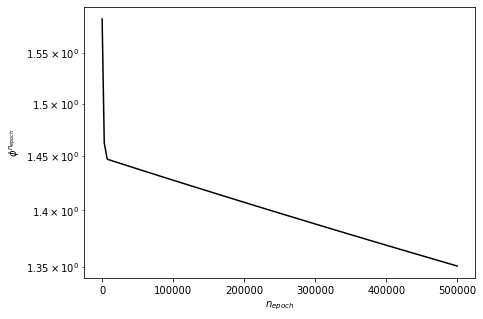

In [102]:
# poissonSolver.plot_solution();
poissonSolver.plot_loss_history();

Text(0.5, 0.92, 'Spatial Error')

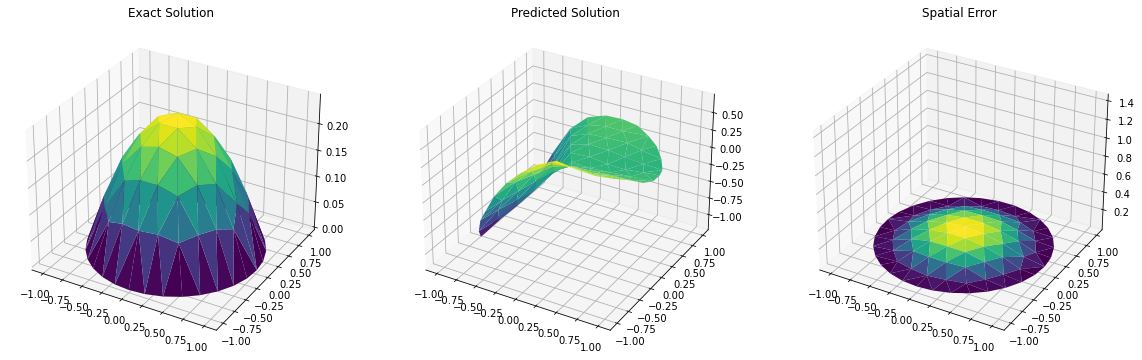

In [103]:
x = p[:,0]
y = p[:,1]
r = np.sqrt(np.square(x) + np.square(y))
u_exact = (-np.square(r)/4) + (1/4)
u_pred = poissonSolver.get_upred(p[:,0], p[:,1])
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(p[:,0], p[:,1], u_exact.flatten(), triangles=t, cmap=plt.cm.viridis)
ax1.set_title("Exact Solution")

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(p[:,0], p[:,1], u_pred.flatten(), triangles=t, cmap=plt.cm.viridis)
ax2.set_title("Predicted Solution")

error = np.abs(u_pred - u_exact)
# error = np.linalg.norm(u_pred - u_exact, np.inf)
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(p[:,0], p[:,1], error.flatten(), triangles=t, cmap=plt.cm.viridis)
ax3.set_title("Spatial Error")

In [104]:
np.linalg.norm(error)

43.21178221121235

## Neumann problem

In [75]:
def generate_square_mesh(n_elements=16):
    # return p and s
    # p are the coordinates, s are the indexes in p that defines each square
    xvalues = np.linspace(0, 1, n_elements)
    yvalues = np.linspace(0, 1, n_elements)
    xx, yy = np.meshgrid(xvalues, yvalues)
    p = []
    j = 0
    e =[]
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x = xx[i][i]
            y = yy[j][j]
            p.append([x,y])
    p = np.vstack(p)
    s = []
    e = []
    for i in range(p.shape[0]):
        point = p[i,:]
        x = point[0]
        y = point[1]
        if (x == 0 and y != 1) or (x == 1 and y != 1):
            e.append([i, i+1])
        if (y == 0 and x!=1) or (y == 1 and x!=1):
            e.append([i, i+n_elements])
        if x == xvalues[-1] or y == yvalues[-1]:
            continue
        p1 = i 
        p2 = i+1
        p3 = i+n_elements
        p4 = i+n_elements+1
        s.append([p1, p2, p3, p4])
    s = np.vstack(s)
    e = np.vstack(e)
    h = 1/n_elements
    return p, s, h, e

In [76]:
p, s, h, e = generate_square_mesh()

In [77]:
# Set boundary
tmin = np.amin(p[:,1])
tmax = np.amax(p[:,1])
xmin = np.amin(p[:,0])
xmax = np.amax(p[:,0])

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

def Neumann_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def Neumann_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

In [78]:
tf.random.set_seed(0)

N_0 = boundary_points.shape[0]
N_b = boundary_points.shape[0]
N_r = p.shape[0] - N_b

# Final time data
t_0 = tf.zeros((N_0,1), dtype=DTYPE) * ub[0]
# print(t_0)
# tf.ones((N_0,1), dtype=DTYPE) * ub[0]
x_0 = tf.zeros((N_0,1), dtype=DTYPE) * ub[0]
# tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = Neumann_u_0(x_0)

# Boundary data
t_b = boundary_points[:,1].reshape(-1,1)
x_b = boundary_points[:,0].reshape(-1,1)
u_b = Neumann_u_b(t_b, x_b)
X_b = tf.concat([t_b, x_b], axis=1)

# Collocation points
X_r = tf.cast(tf.convert_to_tensor(collocation_points), tf.float32)

# Collect boundary and inital data in lists
X_data = [X_0,X_b]
u_data = [u_0,u_b]

In [79]:
class NeumannPINNSolver(PINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx, u_tt):
        """Residual of the PDE"""
        f = tf.cos(np.pi * x) - tf.cos(np.pi * t)
        return (-1 * (u_xx+u_tt)) + u - f
    
    def get_r(self):
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            
            u_t = tape.gradient(u, self.t)
            u_xx = tape.gradient(u_x, self.x)
            u_tt = tape.gradient(u_t, self.t)
            
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx, u_tt)

In [80]:
# Initialize model
model = PINN_NeuralNet(lb, ub, num_hidden_layers=2,
                       activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                       kernel_initializer='he_normal')
model.build(input_shape=(None,2))

# Initilize PINN solver
NeumannSolver = NeumannPINNSolver(model, X_r)

In [81]:
# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-5,1e-6,1e-7])

# Solve with Adam optimizer8
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time()
NeumannSolver.solve_with_TFoptimizer(optim, X_data, u_data, N=1000001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 8.96044254e+00
It 00050: loss = 8.65889454e+00
It 00100: loss = 8.36665058e+00
It 00150: loss = 8.08412743e+00
It 00200: loss = 7.81146431e+00
It 00250: loss = 7.54809618e+00
It 00300: loss = 7.29432058e+00
It 00350: loss = 7.04899406e+00
It 00400: loss = 6.81176472e+00
It 00450: loss = 6.58248329e+00
It 00500: loss = 6.36085701e+00
It 00550: loss = 6.14680290e+00
It 00600: loss = 5.94008017e+00
It 00650: loss = 5.74031639e+00
It 00700: loss = 5.54719925e+00
It 00750: loss = 5.36077785e+00
It 00800: loss = 5.18081570e+00
It 00850: loss = 5.00715685e+00
It 00900: loss = 4.83939123e+00
It 00950: loss = 4.67724609e+00
It 01000: loss = 4.51958799e+00
It 01050: loss = 4.36716032e+00
It 01100: loss = 4.22003651e+00
It 01150: loss = 4.07795906e+00
It 01200: loss = 3.94078445e+00
It 01250: loss = 3.80812979e+00
It 01300: loss = 3.68019772e+00
It 01350: loss = 3.55652046e+00
It 01400: loss = 3.43711686e+00
It 01450: loss = 3.32185745e+00
It 01500: loss = 3.21061540e+00
It 01550

It 13050: loss = 7.53061175e-01
It 13100: loss = 7.52640784e-01
It 13150: loss = 7.52220869e-01
It 13200: loss = 7.51800716e-01
It 13250: loss = 7.51381040e-01
It 13300: loss = 7.50961542e-01
It 13350: loss = 7.50542462e-01
It 13400: loss = 7.50123501e-01
It 13450: loss = 7.49705017e-01
It 13500: loss = 7.49286652e-01
It 13550: loss = 7.48868585e-01
It 13600: loss = 7.48450756e-01
It 13650: loss = 7.48033047e-01
It 13700: loss = 7.47615814e-01
It 13750: loss = 7.47198939e-01
It 13800: loss = 7.46782422e-01
It 13850: loss = 7.46366382e-01
It 13900: loss = 7.45950520e-01
It 13950: loss = 7.45534956e-01
It 14000: loss = 7.45119810e-01
It 14050: loss = 7.44704723e-01
It 14100: loss = 7.44290173e-01
It 14150: loss = 7.43875623e-01
It 14200: loss = 7.43461490e-01
It 14250: loss = 7.43047655e-01
It 14300: loss = 7.42634058e-01
It 14350: loss = 7.42220581e-01
It 14400: loss = 7.41807699e-01
It 14450: loss = 7.41394818e-01
It 14500: loss = 7.40982413e-01
It 14550: loss = 7.40570307e-01
It 14600

It 25900: loss = 6.54543877e-01
It 25950: loss = 6.54198050e-01
It 26000: loss = 6.53851926e-01
It 26050: loss = 6.53505981e-01
It 26100: loss = 6.53160691e-01
It 26150: loss = 6.52815700e-01
It 26200: loss = 6.52471066e-01
It 26250: loss = 6.52126729e-01
It 26300: loss = 6.51782632e-01
It 26350: loss = 6.51438773e-01
It 26400: loss = 6.51095212e-01
It 26450: loss = 6.50752008e-01
It 26500: loss = 6.50408924e-01
It 26550: loss = 6.50066197e-01
It 26600: loss = 6.49723589e-01
It 26650: loss = 6.49381399e-01
It 26700: loss = 6.49039507e-01
It 26750: loss = 6.48697734e-01
It 26800: loss = 6.48356378e-01
It 26850: loss = 6.48015141e-01
It 26900: loss = 6.47674143e-01
It 26950: loss = 6.47333503e-01
It 27000: loss = 6.46992981e-01
It 27050: loss = 6.46652937e-01
It 27100: loss = 6.46313131e-01
It 27150: loss = 6.45973563e-01
It 27200: loss = 6.45634294e-01
It 27250: loss = 6.45295203e-01
It 27300: loss = 6.44956410e-01
It 27350: loss = 6.44618571e-01
It 27400: loss = 6.44281626e-01
It 27450

It 39200: loss = 5.71817994e-01
It 39250: loss = 5.71538687e-01
It 39300: loss = 5.71259141e-01
It 39350: loss = 5.70980072e-01
It 39400: loss = 5.70701003e-01
It 39450: loss = 5.70422113e-01
It 39500: loss = 5.70143700e-01
It 39550: loss = 5.69865167e-01
It 39600: loss = 5.69586813e-01
It 39650: loss = 5.69308877e-01
It 39700: loss = 5.69031000e-01
It 39750: loss = 5.68753242e-01
It 39800: loss = 5.68475485e-01
It 39850: loss = 5.68197906e-01
It 39900: loss = 5.67920387e-01
It 39950: loss = 5.67642987e-01
It 40000: loss = 5.67365944e-01
It 40050: loss = 5.67089200e-01
It 40100: loss = 5.66812336e-01
It 40150: loss = 5.66535950e-01
It 40200: loss = 5.66259801e-01
It 40250: loss = 5.65983593e-01
It 40300: loss = 5.65707803e-01
It 40350: loss = 5.65432310e-01
It 40400: loss = 5.65156698e-01
It 40450: loss = 5.64881444e-01
It 40500: loss = 5.64606428e-01
It 40550: loss = 5.64331532e-01
It 40600: loss = 5.64056873e-01
It 40650: loss = 5.63782334e-01
It 40700: loss = 5.63508153e-01
It 40750

It 52300: loss = 5.05231380e-01
It 52350: loss = 5.05003572e-01
It 52400: loss = 5.04775882e-01
It 52450: loss = 5.04548252e-01
It 52500: loss = 5.04320979e-01
It 52550: loss = 5.04093885e-01
It 52600: loss = 5.03867030e-01
It 52650: loss = 5.03640056e-01
It 52700: loss = 5.03413439e-01
It 52750: loss = 5.03187060e-01
It 52800: loss = 5.02960682e-01
It 52850: loss = 5.02734661e-01
It 52900: loss = 5.02508819e-01
It 52950: loss = 5.02283096e-01
It 53000: loss = 5.02057731e-01
It 53050: loss = 5.01832247e-01
It 53100: loss = 5.01607239e-01
It 53150: loss = 5.01382351e-01
It 53200: loss = 5.01157701e-01
It 53250: loss = 5.00933051e-01
It 53300: loss = 5.00708699e-01
It 53350: loss = 5.00484586e-01
It 53400: loss = 5.00260592e-01
It 53450: loss = 5.00036776e-01
It 53500: loss = 4.99813259e-01
It 53550: loss = 4.99589890e-01
It 53600: loss = 4.99366671e-01
It 53650: loss = 4.99143571e-01
It 53700: loss = 4.98920768e-01
It 53750: loss = 4.98698145e-01
It 53800: loss = 4.98475671e-01
It 53850

It 65300: loss = 4.52420831e-01
It 65350: loss = 4.52242136e-01
It 65400: loss = 4.52063620e-01
It 65450: loss = 4.51884985e-01
It 65500: loss = 4.51706767e-01
It 65550: loss = 4.51528847e-01
It 65600: loss = 4.51350987e-01
It 65650: loss = 4.51173335e-01
It 65700: loss = 4.50995982e-01
It 65750: loss = 4.50818837e-01
It 65800: loss = 4.50641721e-01
It 65850: loss = 4.50464755e-01
It 65900: loss = 4.50288296e-01
It 65950: loss = 4.50111866e-01
It 66000: loss = 4.49935913e-01
It 66050: loss = 4.49760377e-01
It 66100: loss = 4.49584961e-01
It 66150: loss = 4.49409902e-01
It 66200: loss = 4.49234933e-01
It 66250: loss = 4.49060053e-01
It 66300: loss = 4.48885441e-01
It 66350: loss = 4.48711008e-01
It 66400: loss = 4.48536664e-01
It 66450: loss = 4.48362678e-01
It 66500: loss = 4.48188692e-01
It 66550: loss = 4.48015004e-01
It 66600: loss = 4.47841406e-01
It 66650: loss = 4.47668105e-01
It 66700: loss = 4.47494984e-01
It 66750: loss = 4.47322071e-01
It 66800: loss = 4.47149217e-01
It 66850

It 78550: loss = 4.11798149e-01
It 78600: loss = 4.11669344e-01
It 78650: loss = 4.11540806e-01
It 78700: loss = 4.11412567e-01
It 78750: loss = 4.11284387e-01
It 78800: loss = 4.11156446e-01
It 78850: loss = 4.11028683e-01
It 78900: loss = 4.10900950e-01
It 78950: loss = 4.10773665e-01
It 79000: loss = 4.10646439e-01
It 79050: loss = 4.10519242e-01
It 79100: loss = 4.10392493e-01
It 79150: loss = 4.10265625e-01
It 79200: loss = 4.10139114e-01
It 79250: loss = 4.10012901e-01
It 79300: loss = 4.09886748e-01
It 79350: loss = 4.09760833e-01
It 79400: loss = 4.09635186e-01
It 79450: loss = 4.09509540e-01
It 79500: loss = 4.09384310e-01
It 79550: loss = 4.09259140e-01
It 79600: loss = 4.09134179e-01
It 79650: loss = 4.09009278e-01
It 79700: loss = 4.08884645e-01
It 79750: loss = 4.08760309e-01
It 79800: loss = 4.08636093e-01
It 79850: loss = 4.08511937e-01
It 79900: loss = 4.08388019e-01
It 79950: loss = 4.08264428e-01
It 80000: loss = 4.08140779e-01
It 80050: loss = 4.08017665e-01
It 80100

It 91700: loss = 3.84185612e-01
It 91750: loss = 3.84102702e-01
It 91800: loss = 3.84019911e-01
It 91850: loss = 3.83937389e-01
It 91900: loss = 3.83855343e-01
It 91950: loss = 3.83773446e-01
It 92000: loss = 3.83691669e-01
It 92050: loss = 3.83610040e-01
It 92100: loss = 3.83528501e-01
It 92150: loss = 3.83447170e-01
It 92200: loss = 3.83366138e-01
It 92250: loss = 3.83285105e-01
It 92300: loss = 3.83204520e-01
It 92350: loss = 3.83123875e-01
It 92400: loss = 3.83043349e-01
It 92450: loss = 3.82963121e-01
It 92500: loss = 3.82882953e-01
It 92550: loss = 3.82803112e-01
It 92600: loss = 3.82723272e-01
It 92650: loss = 3.82643700e-01
It 92700: loss = 3.82564366e-01
It 92750: loss = 3.82484943e-01
It 92800: loss = 3.82405847e-01
It 92850: loss = 3.82326901e-01
It 92900: loss = 3.82248044e-01
It 92950: loss = 3.82169396e-01
It 93000: loss = 3.82090658e-01
It 93050: loss = 3.82011741e-01
It 93100: loss = 3.81933182e-01
It 93150: loss = 3.81854862e-01
It 93200: loss = 3.81776541e-01
It 93250

It 104600: loss = 3.67683530e-01
It 104650: loss = 3.67637157e-01
It 104700: loss = 3.67590934e-01
It 104750: loss = 3.67544889e-01
It 104800: loss = 3.67498815e-01
It 104850: loss = 3.67453039e-01
It 104900: loss = 3.67407292e-01
It 104950: loss = 3.67361605e-01
It 105000: loss = 3.67316097e-01
It 105050: loss = 3.67270738e-01
It 105100: loss = 3.67225528e-01
It 105150: loss = 3.67180228e-01
It 105200: loss = 3.67135137e-01
It 105250: loss = 3.67090076e-01
It 105300: loss = 3.67045254e-01
It 105350: loss = 3.67000341e-01
It 105400: loss = 3.66955638e-01
It 105450: loss = 3.66910875e-01
It 105500: loss = 3.66866320e-01
It 105550: loss = 3.66821945e-01
It 105600: loss = 3.66777599e-01
It 105650: loss = 3.66733253e-01
It 105700: loss = 3.66689205e-01
It 105750: loss = 3.66645098e-01
It 105800: loss = 3.66601139e-01
It 105850: loss = 3.66557240e-01
It 105900: loss = 3.66513610e-01
It 105950: loss = 3.66469890e-01
It 106000: loss = 3.66426408e-01
It 106050: loss = 3.66382986e-01
It 106100:

It 117250: loss = 3.58842999e-01
It 117300: loss = 3.58817518e-01
It 117350: loss = 3.58791947e-01
It 117400: loss = 3.58766466e-01
It 117450: loss = 3.58740956e-01
It 117500: loss = 3.58715534e-01
It 117550: loss = 3.58690202e-01
It 117600: loss = 3.58664930e-01
It 117650: loss = 3.58639657e-01
It 117700: loss = 3.58614385e-01
It 117750: loss = 3.58589113e-01
It 117800: loss = 3.58563989e-01
It 117850: loss = 3.58538747e-01
It 117900: loss = 3.58513594e-01
It 117950: loss = 3.58488560e-01
It 118000: loss = 3.58463407e-01
It 118050: loss = 3.58438373e-01
It 118100: loss = 3.58413339e-01
It 118150: loss = 3.58388424e-01
It 118200: loss = 3.58363450e-01
It 118250: loss = 3.58338505e-01
It 118300: loss = 3.58313620e-01
It 118350: loss = 3.58288765e-01
It 118400: loss = 3.58263969e-01
It 118450: loss = 3.58239174e-01
It 118500: loss = 3.58214378e-01
It 118550: loss = 3.58189583e-01
It 118600: loss = 3.58164907e-01
It 118650: loss = 3.58140141e-01
It 118700: loss = 3.58115554e-01
It 118750:

It 130100: loss = 3.53016913e-01
It 130150: loss = 3.52995753e-01
It 130200: loss = 3.52974713e-01
It 130250: loss = 3.52953613e-01
It 130300: loss = 3.52932632e-01
It 130350: loss = 3.52911651e-01
It 130400: loss = 3.52890581e-01
It 130450: loss = 3.52869630e-01
It 130500: loss = 3.52848649e-01
It 130550: loss = 3.52827609e-01
It 130600: loss = 3.52806628e-01
It 130650: loss = 3.52785587e-01
It 130700: loss = 3.52764726e-01
It 130750: loss = 3.52743655e-01
It 130800: loss = 3.52722734e-01
It 130850: loss = 3.52701783e-01
It 130900: loss = 3.52680802e-01
It 130950: loss = 3.52659822e-01
It 131000: loss = 3.52638900e-01
It 131050: loss = 3.52617860e-01
It 131100: loss = 3.52596968e-01
It 131150: loss = 3.52576017e-01
It 131200: loss = 3.52555156e-01
It 131250: loss = 3.52534145e-01
It 131300: loss = 3.52513343e-01
It 131350: loss = 3.52492511e-01
It 131400: loss = 3.52471530e-01
It 131450: loss = 3.52450728e-01
It 131500: loss = 3.52429837e-01
It 131550: loss = 3.52408946e-01
It 131600:

It 143000: loss = 3.47924262e-01
It 143050: loss = 3.47905278e-01
It 143100: loss = 3.47886443e-01
It 143150: loss = 3.47867489e-01
It 143200: loss = 3.47848564e-01
It 143250: loss = 3.47829580e-01
It 143300: loss = 3.47810775e-01
It 143350: loss = 3.47791880e-01
It 143400: loss = 3.47773015e-01
It 143450: loss = 3.47754091e-01
It 143500: loss = 3.47735316e-01
It 143550: loss = 3.47716421e-01
It 143600: loss = 3.47697556e-01
It 143650: loss = 3.47678691e-01
It 143700: loss = 3.47659886e-01
It 143750: loss = 3.47641081e-01
It 143800: loss = 3.47622365e-01
It 143850: loss = 3.47603500e-01
It 143900: loss = 3.47584754e-01
It 143950: loss = 3.47565979e-01
It 144000: loss = 3.47547203e-01
It 144050: loss = 3.47528577e-01
It 144100: loss = 3.47510040e-01
It 144150: loss = 3.47491503e-01
It 144200: loss = 3.47472966e-01
It 144250: loss = 3.47454429e-01
It 144300: loss = 3.47435862e-01
It 144350: loss = 3.47417414e-01
It 144400: loss = 3.47398907e-01
It 144450: loss = 3.47380340e-01
It 144500:

It 155500: loss = 3.43400061e-01
It 155550: loss = 3.43381017e-01
It 155600: loss = 3.43362033e-01
It 155650: loss = 3.43343049e-01
It 155700: loss = 3.43324214e-01
It 155750: loss = 3.43305469e-01
It 155800: loss = 3.43286723e-01
It 155850: loss = 3.43268037e-01
It 155900: loss = 3.43249381e-01
It 155950: loss = 3.43230635e-01
It 156000: loss = 3.43212008e-01
It 156050: loss = 3.43193382e-01
It 156100: loss = 3.43174785e-01
It 156150: loss = 3.43156099e-01
It 156200: loss = 3.43137592e-01
It 156250: loss = 3.43118966e-01
It 156300: loss = 3.43100429e-01
It 156350: loss = 3.43081951e-01
It 156400: loss = 3.43063533e-01
It 156450: loss = 3.43045115e-01
It 156500: loss = 3.43026668e-01
It 156550: loss = 3.43008310e-01
It 156600: loss = 3.42989922e-01
It 156650: loss = 3.42971534e-01
It 156700: loss = 3.42953146e-01
It 156750: loss = 3.42934847e-01
It 156800: loss = 3.42916489e-01
It 156850: loss = 3.42898220e-01
It 156900: loss = 3.42879891e-01
It 156950: loss = 3.42861533e-01
It 157000:

It 168400: loss = 3.38908404e-01
It 168450: loss = 3.38891506e-01
It 168500: loss = 3.38874638e-01
It 168550: loss = 3.38857770e-01
It 168600: loss = 3.38840842e-01
It 168650: loss = 3.38823974e-01
It 168700: loss = 3.38807225e-01
It 168750: loss = 3.38790327e-01
It 168800: loss = 3.38773489e-01
It 168850: loss = 3.38756651e-01
It 168900: loss = 3.38739753e-01
It 168950: loss = 3.38723004e-01
It 169000: loss = 3.38706076e-01
It 169050: loss = 3.38689268e-01
It 169100: loss = 3.38672370e-01
It 169150: loss = 3.38655502e-01
It 169200: loss = 3.38638633e-01
It 169250: loss = 3.38621885e-01
It 169300: loss = 3.38605106e-01
It 169350: loss = 3.38588238e-01
It 169400: loss = 3.38571429e-01
It 169450: loss = 3.38554591e-01
It 169500: loss = 3.38537872e-01
It 169550: loss = 3.38520974e-01
It 169600: loss = 3.38504165e-01
It 169650: loss = 3.38487327e-01
It 169700: loss = 3.38470548e-01
It 169750: loss = 3.38453770e-01
It 169800: loss = 3.38436931e-01
It 169850: loss = 3.38420212e-01
It 169900:

It 181100: loss = 3.34711462e-01
It 181150: loss = 3.34695578e-01
It 181200: loss = 3.34679604e-01
It 181250: loss = 3.34663659e-01
It 181300: loss = 3.34647745e-01
It 181350: loss = 3.34631741e-01
It 181400: loss = 3.34615856e-01
It 181450: loss = 3.34599882e-01
It 181500: loss = 3.34584028e-01
It 181550: loss = 3.34568173e-01
It 181600: loss = 3.34552169e-01
It 181650: loss = 3.34536344e-01
It 181700: loss = 3.34520429e-01
It 181750: loss = 3.34504455e-01
It 181800: loss = 3.34488541e-01
It 181850: loss = 3.34472716e-01
It 181900: loss = 3.34456742e-01
It 181950: loss = 3.34440827e-01
It 182000: loss = 3.34424973e-01
It 182050: loss = 3.34409088e-01
It 182100: loss = 3.34393263e-01
It 182150: loss = 3.34377348e-01
It 182200: loss = 3.34361434e-01
It 182250: loss = 3.34345520e-01
It 182300: loss = 3.34329605e-01
It 182350: loss = 3.34313720e-01
It 182400: loss = 3.34297836e-01
It 182450: loss = 3.34281921e-01
It 182500: loss = 3.34266096e-01
It 182550: loss = 3.34250242e-01
It 182600:

It 193850: loss = 3.30885887e-01
It 193900: loss = 3.30871403e-01
It 193950: loss = 3.30857098e-01
It 194000: loss = 3.30842704e-01
It 194050: loss = 3.30828398e-01
It 194100: loss = 3.30813974e-01
It 194150: loss = 3.30799669e-01
It 194200: loss = 3.30785275e-01
It 194250: loss = 3.30770910e-01
It 194300: loss = 3.30756664e-01
It 194350: loss = 3.30742359e-01
It 194400: loss = 3.30727935e-01
It 194450: loss = 3.30713630e-01
It 194500: loss = 3.30699414e-01
It 194550: loss = 3.30685079e-01
It 194600: loss = 3.30670774e-01
It 194650: loss = 3.30656469e-01
It 194700: loss = 3.30642164e-01
It 194750: loss = 3.30627888e-01
It 194800: loss = 3.30613583e-01
It 194850: loss = 3.30599368e-01
It 194900: loss = 3.30585092e-01
It 194950: loss = 3.30570787e-01
It 195000: loss = 3.30556482e-01
It 195050: loss = 3.30542266e-01
It 195100: loss = 3.30528051e-01
It 195150: loss = 3.30513775e-01
It 195200: loss = 3.30499560e-01
It 195250: loss = 3.30485255e-01
It 195300: loss = 3.30470979e-01
It 195350:

It 206600: loss = 3.27332228e-01
It 206650: loss = 3.27318788e-01
It 206700: loss = 3.27305436e-01
It 206750: loss = 3.27291965e-01
It 206800: loss = 3.27278435e-01
It 206850: loss = 3.27264011e-01
It 206900: loss = 3.27249557e-01
It 206950: loss = 3.27235281e-01
It 207000: loss = 3.27221006e-01
It 207050: loss = 3.27206671e-01
It 207100: loss = 3.27192485e-01
It 207150: loss = 3.27178270e-01
It 207200: loss = 3.27164173e-01
It 207250: loss = 3.27150047e-01
It 207300: loss = 3.27136070e-01
It 207350: loss = 3.27121913e-01
It 207400: loss = 3.27107877e-01
It 207450: loss = 3.27093840e-01
It 207500: loss = 3.27079773e-01
It 207550: loss = 3.27065736e-01
It 207600: loss = 3.27051699e-01
It 207650: loss = 3.27037722e-01
It 207700: loss = 3.27023834e-01
It 207750: loss = 3.27009857e-01
It 207800: loss = 3.26995939e-01
It 207850: loss = 3.26981902e-01
It 207900: loss = 3.26968014e-01
It 207950: loss = 3.26954037e-01
It 208000: loss = 3.26940119e-01
It 208050: loss = 3.26926112e-01
It 208100:

It 219050: loss = 3.23884010e-01
It 219100: loss = 3.23870808e-01
It 219150: loss = 3.23857635e-01
It 219200: loss = 3.23844492e-01
It 219250: loss = 3.23831379e-01
It 219300: loss = 3.23818207e-01
It 219350: loss = 3.23805273e-01
It 219400: loss = 3.23792309e-01
It 219450: loss = 3.23779404e-01
It 219500: loss = 3.23766470e-01
It 219550: loss = 3.23753566e-01
It 219600: loss = 3.23740721e-01
It 219650: loss = 3.23727787e-01
It 219700: loss = 3.23714912e-01
It 219750: loss = 3.23702008e-01
It 219800: loss = 3.23689073e-01
It 219850: loss = 3.23676109e-01
It 219900: loss = 3.23663235e-01
It 219950: loss = 3.23650271e-01
It 220000: loss = 3.23637336e-01
It 220050: loss = 3.23624343e-01
It 220100: loss = 3.23611438e-01
It 220150: loss = 3.23598474e-01
It 220200: loss = 3.23585540e-01
It 220250: loss = 3.23572606e-01
It 220300: loss = 3.23559642e-01
It 220350: loss = 3.23546708e-01
It 220400: loss = 3.23533773e-01
It 220450: loss = 3.23520929e-01
It 220500: loss = 3.23507994e-01
It 220550:

It 231900: loss = 3.20717901e-01
It 231950: loss = 3.20706636e-01
It 232000: loss = 3.20695400e-01
It 232050: loss = 3.20684195e-01
It 232100: loss = 3.20672959e-01
It 232150: loss = 3.20661724e-01
It 232200: loss = 3.20650458e-01
It 232250: loss = 3.20639282e-01
It 232300: loss = 3.20627987e-01
It 232350: loss = 3.20616841e-01
It 232400: loss = 3.20605516e-01
It 232450: loss = 3.20594311e-01
It 232500: loss = 3.20583045e-01
It 232550: loss = 3.20571810e-01
It 232600: loss = 3.20560545e-01
It 232650: loss = 3.20549339e-01
It 232700: loss = 3.20538163e-01
It 232750: loss = 3.20526868e-01
It 232800: loss = 3.20515662e-01
It 232850: loss = 3.20504367e-01
It 232900: loss = 3.20493191e-01
It 232950: loss = 3.20481896e-01
It 233000: loss = 3.20470572e-01
It 233050: loss = 3.20457935e-01
It 233100: loss = 3.20445508e-01
It 233150: loss = 3.20433050e-01
It 233200: loss = 3.20420742e-01
It 233250: loss = 3.20408583e-01
It 233300: loss = 3.20396423e-01
It 233350: loss = 3.20384353e-01
It 233400:

It 244350: loss = 3.17893445e-01
It 244400: loss = 3.17882180e-01
It 244450: loss = 3.17871034e-01
It 244500: loss = 3.17859858e-01
It 244550: loss = 3.17848712e-01
It 244600: loss = 3.17837656e-01
It 244650: loss = 3.17826688e-01
It 244700: loss = 3.17815781e-01
It 244750: loss = 3.17804813e-01
It 244800: loss = 3.17793906e-01
It 244850: loss = 3.17783058e-01
It 244900: loss = 3.17772061e-01
It 244950: loss = 3.17761064e-01
It 245000: loss = 3.17750216e-01
It 245050: loss = 3.17739248e-01
It 245100: loss = 3.17728341e-01
It 245150: loss = 3.17717433e-01
It 245200: loss = 3.17706406e-01
It 245250: loss = 3.17695528e-01
It 245300: loss = 3.17684591e-01
It 245350: loss = 3.17673713e-01
It 245400: loss = 3.17662716e-01
It 245450: loss = 3.17651868e-01
It 245500: loss = 3.17640930e-01
It 245550: loss = 3.17630053e-01
It 245600: loss = 3.17619205e-01
It 245650: loss = 3.17608237e-01
It 245700: loss = 3.17597389e-01
It 245750: loss = 3.17586452e-01
It 245800: loss = 3.17575544e-01
It 245850:

It 257000: loss = 3.15249324e-01
It 257050: loss = 3.15239280e-01
It 257100: loss = 3.15229267e-01
It 257150: loss = 3.15219164e-01
It 257200: loss = 3.15209210e-01
It 257250: loss = 3.15199137e-01
It 257300: loss = 3.15189123e-01
It 257350: loss = 3.15179020e-01
It 257400: loss = 3.15169007e-01
It 257450: loss = 3.15158904e-01
It 257500: loss = 3.15148950e-01
It 257550: loss = 3.15138847e-01
It 257600: loss = 3.15128863e-01
It 257650: loss = 3.15118819e-01
It 257700: loss = 3.15108716e-01
It 257750: loss = 3.15098792e-01
It 257800: loss = 3.15088749e-01
It 257850: loss = 3.15078735e-01
It 257900: loss = 3.15068632e-01
It 257950: loss = 3.15058649e-01
It 258000: loss = 3.15048635e-01
It 258050: loss = 3.15038651e-01
It 258100: loss = 3.15028578e-01
It 258150: loss = 3.15018594e-01
It 258200: loss = 3.15008640e-01
It 258250: loss = 3.14998597e-01
It 258300: loss = 3.14988583e-01
It 258350: loss = 3.14978570e-01
It 258400: loss = 3.14968556e-01
It 258450: loss = 3.14958572e-01
It 258500:

It 269850: loss = 3.12709689e-01
It 269900: loss = 3.12700629e-01
It 269950: loss = 3.12691689e-01
It 270000: loss = 3.12682718e-01
It 270050: loss = 3.12673748e-01
It 270100: loss = 3.12664807e-01
It 270150: loss = 3.12655866e-01
It 270200: loss = 3.12646925e-01
It 270250: loss = 3.12637955e-01
It 270300: loss = 3.12629044e-01
It 270350: loss = 3.12620074e-01
It 270400: loss = 3.12611222e-01
It 270450: loss = 3.12602282e-01
It 270500: loss = 3.12593281e-01
It 270550: loss = 3.12584370e-01
It 270600: loss = 3.12575459e-01
It 270650: loss = 3.12566519e-01
It 270700: loss = 3.12557638e-01
It 270750: loss = 3.12548697e-01
It 270800: loss = 3.12539786e-01
It 270850: loss = 3.12530935e-01
It 270900: loss = 3.12522024e-01
It 270950: loss = 3.12513024e-01
It 271000: loss = 3.12504113e-01
It 271050: loss = 3.12495112e-01
It 271100: loss = 3.12486202e-01
It 271150: loss = 3.12477201e-01
It 271200: loss = 3.12468320e-01
It 271250: loss = 3.12459409e-01
It 271300: loss = 3.12450409e-01
It 271350:

It 282500: loss = 3.10468942e-01
It 282550: loss = 3.10460150e-01
It 282600: loss = 3.10451418e-01
It 282650: loss = 3.10442686e-01
It 282700: loss = 3.10433984e-01
It 282750: loss = 3.10425252e-01
It 282800: loss = 3.10416490e-01
It 282850: loss = 3.10407698e-01
It 282900: loss = 3.10399026e-01
It 282950: loss = 3.10390294e-01
It 283000: loss = 3.10381591e-01
It 283050: loss = 3.10372829e-01
It 283100: loss = 3.10364097e-01
It 283150: loss = 3.10355395e-01
It 283200: loss = 3.10346663e-01
It 283250: loss = 3.10337901e-01
It 283300: loss = 3.10329199e-01
It 283350: loss = 3.10320497e-01
It 283400: loss = 3.10311735e-01
It 283450: loss = 3.10303062e-01
It 283500: loss = 3.10294390e-01
It 283550: loss = 3.10285658e-01
It 283600: loss = 3.10276926e-01
It 283650: loss = 3.10268193e-01
It 283700: loss = 3.10259581e-01
It 283750: loss = 3.10250789e-01
It 283800: loss = 3.10242116e-01
It 283850: loss = 3.10233384e-01
It 283900: loss = 3.10224742e-01
It 283950: loss = 3.10215950e-01
It 284000:

It 295300: loss = 3.08266044e-01
It 295350: loss = 3.08257580e-01
It 295400: loss = 3.08249176e-01
It 295450: loss = 3.08240652e-01
It 295500: loss = 3.08232188e-01
It 295550: loss = 3.08223695e-01
It 295600: loss = 3.08215320e-01
It 295650: loss = 3.08206767e-01
It 295700: loss = 3.08198273e-01
It 295750: loss = 3.08189839e-01
It 295800: loss = 3.08181345e-01
It 295850: loss = 3.08172911e-01
It 295900: loss = 3.08164477e-01
It 295950: loss = 3.08156013e-01
It 296000: loss = 3.08147550e-01
It 296050: loss = 3.08139116e-01
It 296100: loss = 3.08130652e-01
It 296150: loss = 3.08122158e-01
It 296200: loss = 3.08113694e-01
It 296250: loss = 3.08105260e-01
It 296300: loss = 3.08096766e-01
It 296350: loss = 3.08088362e-01
It 296400: loss = 3.08079898e-01
It 296450: loss = 3.08071464e-01
It 296500: loss = 3.08063060e-01
It 296550: loss = 3.08054566e-01
It 296600: loss = 3.08046162e-01
It 296650: loss = 3.08037668e-01
It 296700: loss = 3.08029234e-01
It 296750: loss = 3.08020681e-01
It 296800:

It 307850: loss = 3.06151152e-01
It 307900: loss = 3.06142867e-01
It 307950: loss = 3.06134462e-01
It 308000: loss = 3.06126177e-01
It 308050: loss = 3.06117833e-01
It 308100: loss = 3.06109458e-01
It 308150: loss = 3.06101143e-01
It 308200: loss = 3.06092739e-01
It 308250: loss = 3.06084394e-01
It 308300: loss = 3.06076050e-01
It 308350: loss = 3.06067705e-01
It 308400: loss = 3.06059390e-01
It 308450: loss = 3.06051075e-01
It 308500: loss = 3.06042671e-01
It 308550: loss = 3.06034386e-01
It 308600: loss = 3.06026042e-01
It 308650: loss = 3.06017697e-01
It 308700: loss = 3.06009352e-01
It 308750: loss = 3.06001008e-01
It 308800: loss = 3.05992663e-01
It 308850: loss = 3.05984288e-01
It 308900: loss = 3.05976033e-01
It 308950: loss = 3.05967718e-01
It 309000: loss = 3.05959344e-01
It 309050: loss = 3.05951118e-01
It 309100: loss = 3.05942774e-01
It 309150: loss = 3.05934370e-01
It 309200: loss = 3.05926085e-01
It 309250: loss = 3.05917770e-01
It 309300: loss = 3.05909455e-01
It 309350:

It 320650: loss = 3.04042071e-01
It 320700: loss = 3.04033965e-01
It 320750: loss = 3.04025829e-01
It 320800: loss = 3.04017693e-01
It 320850: loss = 3.04009616e-01
It 320900: loss = 3.04001510e-01
It 320950: loss = 3.03993404e-01
It 321000: loss = 3.03985268e-01
It 321050: loss = 3.03977132e-01
It 321100: loss = 3.03969026e-01
It 321150: loss = 3.03960919e-01
It 321200: loss = 3.03952754e-01
It 321250: loss = 3.03944707e-01
It 321300: loss = 3.03936541e-01
It 321350: loss = 3.03928435e-01
It 321400: loss = 3.03920329e-01
It 321450: loss = 3.03912193e-01
It 321500: loss = 3.03904146e-01
It 321550: loss = 3.03896010e-01
It 321600: loss = 3.03887904e-01
It 321650: loss = 3.03879768e-01
It 321700: loss = 3.03871691e-01
It 321750: loss = 3.03863555e-01
It 321800: loss = 3.03855419e-01
It 321850: loss = 3.03847402e-01
It 321900: loss = 3.03839266e-01
It 321950: loss = 3.03831190e-01
It 322000: loss = 3.03823054e-01
It 322050: loss = 3.03815007e-01
It 322100: loss = 3.03806841e-01
It 322150:

It 333400: loss = 3.02011222e-01
It 333450: loss = 3.02003443e-01
It 333500: loss = 3.01995724e-01
It 333550: loss = 3.01987946e-01
It 333600: loss = 3.01980197e-01
It 333650: loss = 3.01972449e-01
It 333700: loss = 3.01964670e-01
It 333750: loss = 3.01956952e-01
It 333800: loss = 3.01949203e-01
It 333850: loss = 3.01941454e-01
It 333900: loss = 3.01933646e-01
It 333950: loss = 3.01925898e-01
It 334000: loss = 3.01918119e-01
It 334050: loss = 3.01910430e-01
It 334100: loss = 3.01902682e-01
It 334150: loss = 3.01894903e-01
It 334200: loss = 3.01887006e-01
It 334250: loss = 3.01879168e-01
It 334300: loss = 3.01871300e-01
It 334350: loss = 3.01863402e-01
It 334400: loss = 3.01855564e-01
It 334450: loss = 3.01847696e-01
It 334500: loss = 3.01839918e-01
It 334550: loss = 3.01832139e-01
It 334600: loss = 3.01824331e-01
It 334650: loss = 3.01816523e-01
It 334700: loss = 3.01808655e-01
It 334750: loss = 3.01800877e-01
It 334800: loss = 3.01793098e-01
It 334850: loss = 3.01785231e-01
It 334900:

It 346200: loss = 3.00023675e-01
It 346250: loss = 3.00016046e-01
It 346300: loss = 3.00008535e-01
It 346350: loss = 3.00000906e-01
It 346400: loss = 2.99993366e-01
It 346450: loss = 2.99985826e-01
It 346500: loss = 2.99978197e-01
It 346550: loss = 2.99970627e-01
It 346600: loss = 2.99963027e-01
It 346650: loss = 2.99955487e-01
It 346700: loss = 2.99947858e-01
It 346750: loss = 2.99940288e-01
It 346800: loss = 2.99932659e-01
It 346850: loss = 2.99925148e-01
It 346900: loss = 2.99917549e-01
It 346950: loss = 2.99910039e-01
It 347000: loss = 2.99902439e-01
It 347050: loss = 2.99894840e-01
It 347100: loss = 2.99887240e-01
It 347150: loss = 2.99879670e-01
It 347200: loss = 2.99872071e-01
It 347250: loss = 2.99864531e-01
It 347300: loss = 2.99856961e-01
It 347350: loss = 2.99849302e-01
It 347400: loss = 2.99841791e-01
It 347450: loss = 2.99834251e-01
It 347500: loss = 2.99826682e-01
It 347550: loss = 2.99819142e-01
It 347600: loss = 2.99811512e-01
It 347650: loss = 2.99803972e-01
It 347700:

It 359000: loss = 2.98079103e-01
It 359050: loss = 2.98071533e-01
It 359100: loss = 2.98063993e-01
It 359150: loss = 2.98056483e-01
It 359200: loss = 2.98048913e-01
It 359250: loss = 2.98041344e-01
It 359300: loss = 2.98033804e-01
It 359350: loss = 2.98026264e-01
It 359400: loss = 2.98018754e-01
It 359450: loss = 2.98011243e-01
It 359500: loss = 2.98003674e-01
It 359550: loss = 2.97996163e-01
It 359600: loss = 2.97988713e-01
It 359650: loss = 2.97981143e-01
It 359700: loss = 2.97973573e-01
It 359750: loss = 2.97966033e-01
It 359800: loss = 2.97958493e-01
It 359850: loss = 2.97950953e-01
It 359900: loss = 2.97943413e-01
It 359950: loss = 2.97935903e-01
It 360000: loss = 2.97928423e-01
It 360050: loss = 2.97920913e-01
It 360100: loss = 2.97913343e-01
It 360150: loss = 2.97905803e-01
It 360200: loss = 2.97898263e-01
It 360250: loss = 2.97890782e-01
It 360300: loss = 2.97883183e-01
It 360350: loss = 2.97875673e-01
It 360400: loss = 2.97868162e-01
It 360450: loss = 2.97860652e-01
It 360500:

It 371550: loss = 2.96236038e-01
It 371600: loss = 2.96228886e-01
It 371650: loss = 2.96221673e-01
It 371700: loss = 2.96214432e-01
It 371750: loss = 2.96207190e-01
It 371800: loss = 2.96200007e-01
It 371850: loss = 2.96192735e-01
It 371900: loss = 2.96185583e-01
It 371950: loss = 2.96178401e-01
It 372000: loss = 2.96171159e-01
It 372050: loss = 2.96163976e-01
It 372100: loss = 2.96156764e-01
It 372150: loss = 2.96149492e-01
It 372200: loss = 2.96142340e-01
It 372250: loss = 2.96135128e-01
It 372300: loss = 2.96127886e-01
It 372350: loss = 2.96120703e-01
It 372400: loss = 2.96113491e-01
It 372450: loss = 2.96106249e-01
It 372500: loss = 2.96099067e-01
It 372550: loss = 2.96091884e-01
It 372600: loss = 2.96084613e-01
It 372650: loss = 2.96077460e-01
It 372700: loss = 2.96070278e-01
It 372750: loss = 2.96063066e-01
It 372800: loss = 2.96055824e-01
It 372850: loss = 2.96048671e-01
It 372900: loss = 2.96041489e-01
It 372950: loss = 2.96034247e-01
It 373000: loss = 2.96027005e-01
It 373050:

It 384100: loss = 2.94465065e-01
It 384150: loss = 2.94458061e-01
It 384200: loss = 2.94451058e-01
It 384250: loss = 2.94444054e-01
It 384300: loss = 2.94437051e-01
It 384350: loss = 2.94430077e-01
It 384400: loss = 2.94423074e-01
It 384450: loss = 2.94416070e-01
It 384500: loss = 2.94409156e-01
It 384550: loss = 2.94402122e-01
It 384600: loss = 2.94395119e-01
It 384650: loss = 2.94388145e-01
It 384700: loss = 2.94381201e-01
It 384750: loss = 2.94374138e-01
It 384800: loss = 2.94367194e-01
It 384850: loss = 2.94360220e-01
It 384900: loss = 2.94353187e-01
It 384950: loss = 2.94346243e-01
It 385000: loss = 2.94339240e-01
It 385050: loss = 2.94332206e-01
It 385100: loss = 2.94325203e-01
It 385150: loss = 2.94318318e-01
It 385200: loss = 2.94311285e-01
It 385250: loss = 2.94304341e-01
It 385300: loss = 2.94297308e-01
It 385350: loss = 2.94290304e-01
It 385400: loss = 2.94283330e-01
It 385450: loss = 2.94276416e-01
It 385500: loss = 2.94269443e-01
It 385550: loss = 2.94262409e-01
It 385600:

It 396550: loss = 2.92745054e-01
It 396600: loss = 2.92738229e-01
It 396650: loss = 2.92731315e-01
It 396700: loss = 2.92724490e-01
It 396750: loss = 2.92717636e-01
It 396800: loss = 2.92710811e-01
It 396850: loss = 2.92703956e-01
It 396900: loss = 2.92697132e-01
It 396950: loss = 2.92690277e-01
It 397000: loss = 2.92683423e-01
It 397050: loss = 2.92676568e-01
It 397100: loss = 2.92669713e-01
It 397150: loss = 2.92662859e-01
It 397200: loss = 2.92656034e-01
It 397250: loss = 2.92649150e-01
It 397300: loss = 2.92642295e-01
It 397350: loss = 2.92635381e-01
It 397400: loss = 2.92628616e-01
It 397450: loss = 2.92621791e-01
It 397500: loss = 2.92614937e-01
It 397550: loss = 2.92608023e-01
It 397600: loss = 2.92601049e-01
It 397650: loss = 2.92594016e-01
It 397700: loss = 2.92587042e-01
It 397750: loss = 2.92580098e-01
It 397800: loss = 2.92573035e-01
It 397850: loss = 2.92566121e-01
It 397900: loss = 2.92559147e-01
It 397950: loss = 2.92552173e-01
It 398000: loss = 2.92545170e-01
It 398050:

It 409050: loss = 2.90972084e-01
It 409100: loss = 2.90965021e-01
It 409150: loss = 2.90957868e-01
It 409200: loss = 2.90950805e-01
It 409250: loss = 2.90943801e-01
It 409300: loss = 2.90936738e-01
It 409350: loss = 2.90929645e-01
It 409400: loss = 2.90922552e-01
It 409450: loss = 2.90915549e-01
It 409500: loss = 2.90908396e-01
It 409550: loss = 2.90901363e-01
It 409600: loss = 2.90894359e-01
It 409650: loss = 2.90887266e-01
It 409700: loss = 2.90880203e-01
It 409750: loss = 2.90873110e-01
It 409800: loss = 2.90866047e-01
It 409850: loss = 2.90858954e-01
It 409900: loss = 2.90851921e-01
It 409950: loss = 2.90844887e-01
It 410000: loss = 2.90837765e-01
It 410050: loss = 2.90830761e-01
It 410100: loss = 2.90823698e-01
It 410150: loss = 2.90816605e-01
It 410200: loss = 2.90809542e-01
It 410250: loss = 2.90802538e-01
It 410300: loss = 2.90795386e-01
It 410350: loss = 2.90788382e-01
It 410400: loss = 2.90781319e-01
It 410450: loss = 2.90774226e-01
It 410500: loss = 2.90767163e-01
It 410550:

It 421800: loss = 2.89181113e-01
It 421850: loss = 2.89174080e-01
It 421900: loss = 2.89167166e-01
It 421950: loss = 2.89160162e-01
It 422000: loss = 2.89153188e-01
It 422050: loss = 2.89146185e-01
It 422100: loss = 2.89139211e-01
It 422150: loss = 2.89132178e-01
It 422200: loss = 2.89125234e-01
It 422250: loss = 2.89118290e-01
It 422300: loss = 2.89111286e-01
It 422350: loss = 2.89104342e-01
It 422400: loss = 2.89097309e-01
It 422450: loss = 2.89090306e-01
It 422500: loss = 2.89083332e-01
It 422550: loss = 2.89076418e-01
It 422600: loss = 2.89069414e-01
It 422650: loss = 2.89062440e-01
It 422700: loss = 2.89055496e-01
It 422750: loss = 2.89048463e-01
It 422800: loss = 2.89041430e-01
It 422850: loss = 2.89034545e-01
It 422900: loss = 2.89027572e-01
It 422950: loss = 2.89020538e-01
It 423000: loss = 2.89013594e-01
It 423050: loss = 2.89006621e-01
It 423100: loss = 2.88999557e-01
It 423150: loss = 2.88992673e-01
It 423200: loss = 2.88985729e-01
It 423250: loss = 2.88978696e-01
It 423300:

It 434450: loss = 2.87423432e-01
It 434500: loss = 2.87416548e-01
It 434550: loss = 2.87409574e-01
It 434600: loss = 2.87402689e-01
It 434650: loss = 2.87395775e-01
It 434700: loss = 2.87388861e-01
It 434750: loss = 2.87382007e-01
It 434800: loss = 2.87375063e-01
It 434850: loss = 2.87368149e-01
It 434900: loss = 2.87361264e-01
It 434950: loss = 2.87354290e-01
It 435000: loss = 2.87347496e-01
It 435050: loss = 2.87340552e-01
It 435100: loss = 2.87333667e-01
It 435150: loss = 2.87326723e-01
It 435200: loss = 2.87319869e-01
It 435250: loss = 2.87312865e-01
It 435300: loss = 2.87306011e-01
It 435350: loss = 2.87299156e-01
It 435400: loss = 2.87292242e-01
It 435450: loss = 2.87285298e-01
It 435500: loss = 2.87278444e-01
It 435550: loss = 2.87271500e-01
It 435600: loss = 2.87264615e-01
It 435650: loss = 2.87257761e-01
It 435700: loss = 2.87250817e-01
It 435750: loss = 2.87243903e-01
It 435800: loss = 2.87236989e-01
It 435850: loss = 2.87230074e-01
It 435900: loss = 2.87223220e-01
It 435950:

It 447350: loss = 2.85664856e-01
It 447400: loss = 2.85658002e-01
It 447450: loss = 2.85651267e-01
It 447500: loss = 2.85644352e-01
It 447550: loss = 2.85637528e-01
It 447600: loss = 2.85630703e-01
It 447650: loss = 2.85623819e-01
It 447700: loss = 2.85617024e-01
It 447750: loss = 2.85610199e-01
It 447800: loss = 2.85603315e-01
It 447850: loss = 2.85596490e-01
It 447900: loss = 2.85589635e-01
It 447950: loss = 2.85582781e-01
It 448000: loss = 2.85575986e-01
It 448050: loss = 2.85569102e-01
It 448100: loss = 2.85562277e-01
It 448150: loss = 2.85555422e-01
It 448200: loss = 2.85548568e-01
It 448250: loss = 2.85541743e-01
It 448300: loss = 2.85534948e-01
It 448350: loss = 2.85528123e-01
It 448400: loss = 2.85521269e-01
It 448450: loss = 2.85514474e-01
It 448500: loss = 2.85507560e-01
It 448550: loss = 2.85500824e-01
It 448600: loss = 2.85493970e-01
It 448650: loss = 2.85487056e-01
It 448700: loss = 2.85480261e-01
It 448750: loss = 2.85473436e-01
It 448800: loss = 2.85466641e-01
It 448850:

It 460150: loss = 2.83933759e-01
It 460200: loss = 2.83927053e-01
It 460250: loss = 2.83920377e-01
It 460300: loss = 2.83913642e-01
It 460350: loss = 2.83906966e-01
It 460400: loss = 2.83900321e-01
It 460450: loss = 2.83893585e-01
It 460500: loss = 2.83886939e-01
It 460550: loss = 2.83880293e-01
It 460600: loss = 2.83873618e-01
It 460650: loss = 2.83866912e-01
It 460700: loss = 2.83860236e-01
It 460750: loss = 2.83853471e-01
It 460800: loss = 2.83846885e-01
It 460850: loss = 2.83840179e-01
It 460900: loss = 2.83833444e-01
It 460950: loss = 2.83826619e-01
It 461000: loss = 2.83819854e-01
It 461050: loss = 2.83813089e-01
It 461100: loss = 2.83806384e-01
It 461150: loss = 2.83799529e-01
It 461200: loss = 2.83792824e-01
It 461250: loss = 2.83786058e-01
It 461300: loss = 2.83779383e-01
It 461350: loss = 2.83772707e-01
It 461400: loss = 2.83765972e-01
It 461450: loss = 2.83759296e-01
It 461500: loss = 2.83752590e-01
It 461550: loss = 2.83745855e-01
It 461600: loss = 2.83739150e-01
It 461650:

It 472600: loss = 2.82287419e-01
It 472650: loss = 2.82280982e-01
It 472700: loss = 2.82274544e-01
It 472750: loss = 2.82268167e-01
It 472800: loss = 2.82261699e-01
It 472850: loss = 2.82255262e-01
It 472900: loss = 2.82248914e-01
It 472950: loss = 2.82242417e-01
It 473000: loss = 2.82235980e-01
It 473050: loss = 2.82229632e-01
It 473100: loss = 2.82223135e-01
It 473150: loss = 2.82216728e-01
It 473200: loss = 2.82210290e-01
It 473250: loss = 2.82203853e-01
It 473300: loss = 2.82197386e-01
It 473350: loss = 2.82191038e-01
It 473400: loss = 2.82184601e-01
It 473450: loss = 2.82178164e-01
It 473500: loss = 2.82171726e-01
It 473550: loss = 2.82165289e-01
It 473600: loss = 2.82158852e-01
It 473650: loss = 2.82152414e-01
It 473700: loss = 2.82146037e-01
It 473750: loss = 2.82139570e-01
It 473800: loss = 2.82133132e-01
It 473850: loss = 2.82126755e-01
It 473900: loss = 2.82120287e-01
It 473950: loss = 2.82113850e-01
It 474000: loss = 2.82107472e-01
It 474050: loss = 2.82101035e-01
It 474100:

It 485050: loss = 2.80722976e-01
It 485100: loss = 2.80716658e-01
It 485150: loss = 2.80710280e-01
It 485200: loss = 2.80703962e-01
It 485250: loss = 2.80697584e-01
It 485300: loss = 2.80691266e-01
It 485350: loss = 2.80684859e-01
It 485400: loss = 2.80678600e-01
It 485450: loss = 2.80672252e-01
It 485500: loss = 2.80665874e-01
It 485550: loss = 2.80659616e-01
It 485600: loss = 2.80653238e-01
It 485650: loss = 2.80646920e-01
It 485700: loss = 2.80640662e-01
It 485750: loss = 2.80634344e-01
It 485800: loss = 2.80627966e-01
It 485850: loss = 2.80621678e-01
It 485900: loss = 2.80615330e-01
It 485950: loss = 2.80609012e-01
It 486000: loss = 2.80602753e-01
It 486050: loss = 2.80596435e-01
It 486100: loss = 2.80590087e-01
It 486150: loss = 2.80583739e-01
It 486200: loss = 2.80577481e-01
It 486250: loss = 2.80571133e-01
It 486300: loss = 2.80564904e-01
It 486350: loss = 2.80558586e-01
It 486400: loss = 2.80552208e-01
It 486450: loss = 2.80545950e-01
It 486500: loss = 2.80539662e-01
It 486550:

It 497900: loss = 2.79146791e-01
It 497950: loss = 2.79140681e-01
It 498000: loss = 2.79134661e-01
It 498050: loss = 2.79128611e-01
It 498100: loss = 2.79122502e-01
It 498150: loss = 2.79116511e-01
It 498200: loss = 2.79110491e-01
It 498250: loss = 2.79104412e-01
It 498300: loss = 2.79098332e-01
It 498350: loss = 2.79092252e-01
It 498400: loss = 2.79086173e-01
It 498450: loss = 2.79080182e-01
It 498500: loss = 2.79074132e-01
It 498550: loss = 2.79068053e-01
It 498600: loss = 2.79062033e-01
It 498650: loss = 2.79055893e-01
It 498700: loss = 2.79049873e-01
It 498750: loss = 2.79043823e-01
It 498800: loss = 2.79037833e-01
It 498850: loss = 2.79031694e-01
It 498900: loss = 2.79025644e-01
It 498950: loss = 2.79019624e-01
It 499000: loss = 2.79013574e-01
It 499050: loss = 2.79007524e-01
It 499100: loss = 2.79001474e-01
It 499150: loss = 2.78995425e-01
It 499200: loss = 2.78989285e-01
It 499250: loss = 2.78983265e-01
It 499300: loss = 2.78977275e-01
It 499350: loss = 2.78971136e-01
It 499400:

It 510750: loss = 2.77612209e-01
It 510800: loss = 2.77606428e-01
It 510850: loss = 2.77600586e-01
It 510900: loss = 2.77594805e-01
It 510950: loss = 2.77589053e-01
It 511000: loss = 2.77583212e-01
It 511050: loss = 2.77577400e-01
It 511100: loss = 2.77571559e-01
It 511150: loss = 2.77565777e-01
It 511200: loss = 2.77559996e-01
It 511250: loss = 2.77554154e-01
It 511300: loss = 2.77548373e-01
It 511350: loss = 2.77542531e-01
It 511400: loss = 2.77536690e-01
It 511450: loss = 2.77530938e-01
It 511500: loss = 2.77525127e-01
It 511550: loss = 2.77519345e-01
It 511600: loss = 2.77513474e-01
It 511650: loss = 2.77507663e-01
It 511700: loss = 2.77501851e-01
It 511750: loss = 2.77496040e-01
It 511800: loss = 2.77490258e-01
It 511850: loss = 2.77484447e-01
It 511900: loss = 2.77478635e-01
It 511950: loss = 2.77472854e-01
It 512000: loss = 2.77467042e-01
It 512050: loss = 2.77461201e-01
It 512100: loss = 2.77455419e-01
It 512150: loss = 2.77449578e-01
It 512200: loss = 2.77443767e-01
It 512250:

It 523400: loss = 2.76144832e-01
It 523450: loss = 2.76139081e-01
It 523500: loss = 2.76133239e-01
It 523550: loss = 2.76127487e-01
It 523600: loss = 2.76121676e-01
It 523650: loss = 2.76115924e-01
It 523700: loss = 2.76110202e-01
It 523750: loss = 2.76104450e-01
It 523800: loss = 2.76098609e-01
It 523850: loss = 2.76092857e-01
It 523900: loss = 2.76087075e-01
It 523950: loss = 2.76081324e-01
It 524000: loss = 2.76075542e-01
It 524050: loss = 2.76069790e-01
It 524100: loss = 2.76064038e-01
It 524150: loss = 2.76058257e-01
It 524200: loss = 2.76052475e-01
It 524250: loss = 2.76046693e-01
It 524300: loss = 2.76040971e-01
It 524350: loss = 2.76035130e-01
It 524400: loss = 2.76029408e-01
It 524450: loss = 2.76023686e-01
It 524500: loss = 2.76017815e-01
It 524550: loss = 2.76012063e-01
It 524600: loss = 2.76006341e-01
It 524650: loss = 2.76000559e-01
It 524700: loss = 2.75994778e-01
It 524750: loss = 2.75988996e-01
It 524800: loss = 2.75983185e-01
It 524850: loss = 2.75977492e-01
It 524900:

It 535900: loss = 2.74706304e-01
It 535950: loss = 2.74700552e-01
It 536000: loss = 2.74694860e-01
It 536050: loss = 2.74689108e-01
It 536100: loss = 2.74683297e-01
It 536150: loss = 2.74677664e-01
It 536200: loss = 2.74671912e-01
It 536250: loss = 2.74666190e-01
It 536300: loss = 2.74660468e-01
It 536350: loss = 2.74654746e-01
It 536400: loss = 2.74648994e-01
It 536450: loss = 2.74643332e-01
It 536500: loss = 2.74637550e-01
It 536550: loss = 2.74631828e-01
It 536600: loss = 2.74626106e-01
It 536650: loss = 2.74620295e-01
It 536700: loss = 2.74614632e-01
It 536750: loss = 2.74608970e-01
It 536800: loss = 2.74603188e-01
It 536850: loss = 2.74597466e-01
It 536900: loss = 2.74591774e-01
It 536950: loss = 2.74585992e-01
It 537000: loss = 2.74580330e-01
It 537050: loss = 2.74574548e-01
It 537100: loss = 2.74568856e-01
It 537150: loss = 2.74563104e-01
It 537200: loss = 2.74557322e-01
It 537250: loss = 2.74551660e-01
It 537300: loss = 2.74545938e-01
It 537350: loss = 2.74540246e-01
It 537400:

It 548650: loss = 2.73260534e-01
It 548700: loss = 2.73254961e-01
It 548750: loss = 2.73249328e-01
It 548800: loss = 2.73243785e-01
It 548850: loss = 2.73238152e-01
It 548900: loss = 2.73232520e-01
It 548950: loss = 2.73226947e-01
It 549000: loss = 2.73221374e-01
It 549050: loss = 2.73215711e-01
It 549100: loss = 2.73210168e-01
It 549150: loss = 2.73204505e-01
It 549200: loss = 2.73198903e-01
It 549250: loss = 2.73193359e-01
It 549300: loss = 2.73187727e-01
It 549350: loss = 2.73182005e-01
It 549400: loss = 2.73176461e-01
It 549450: loss = 2.73170829e-01
It 549500: loss = 2.73165226e-01
It 549550: loss = 2.73159593e-01
It 549600: loss = 2.73153991e-01
It 549650: loss = 2.73148417e-01
It 549700: loss = 2.73142695e-01
It 549750: loss = 2.73137212e-01
It 549800: loss = 2.73131549e-01
It 549850: loss = 2.73125887e-01
It 549900: loss = 2.73120284e-01
It 549950: loss = 2.73114651e-01
It 550000: loss = 2.73109019e-01
It 550050: loss = 2.73103505e-01
It 550100: loss = 2.73097813e-01
It 550150:

It 561100: loss = 2.71865308e-01
It 561150: loss = 2.71859616e-01
It 561200: loss = 2.71853954e-01
It 561250: loss = 2.71848261e-01
It 561300: loss = 2.71842569e-01
It 561350: loss = 2.71836936e-01
It 561400: loss = 2.71831244e-01
It 561450: loss = 2.71825552e-01
It 561500: loss = 2.71819949e-01
It 561550: loss = 2.71814317e-01
It 561600: loss = 2.71808624e-01
It 561650: loss = 2.71802992e-01
It 561700: loss = 2.71797329e-01
It 561750: loss = 2.71791697e-01
It 561800: loss = 2.71786004e-01
It 561850: loss = 2.71780431e-01
It 561900: loss = 2.71774799e-01
It 561950: loss = 2.71769136e-01
It 562000: loss = 2.71763474e-01
It 562050: loss = 2.71757871e-01
It 562100: loss = 2.71752268e-01
It 562150: loss = 2.71746606e-01
It 562200: loss = 2.71741003e-01
It 562250: loss = 2.71735340e-01
It 562300: loss = 2.71729708e-01
It 562350: loss = 2.71723986e-01
It 562400: loss = 2.71718413e-01
It 562450: loss = 2.71712810e-01
It 562500: loss = 2.71707118e-01
It 562550: loss = 2.71701515e-01
It 562600:

It 574000: loss = 2.70419836e-01
It 574050: loss = 2.70414263e-01
It 574100: loss = 2.70408630e-01
It 574150: loss = 2.70403057e-01
It 574200: loss = 2.70397395e-01
It 574250: loss = 2.70391732e-01
It 574300: loss = 2.70386219e-01
It 574350: loss = 2.70380586e-01
It 574400: loss = 2.70374894e-01
It 574450: loss = 2.70369381e-01
It 574500: loss = 2.70363748e-01
It 574550: loss = 2.70358145e-01
It 574600: loss = 2.70352572e-01
It 574650: loss = 2.70346910e-01
It 574700: loss = 2.70341396e-01
It 574750: loss = 2.70335674e-01
It 574800: loss = 2.70330161e-01
It 574850: loss = 2.70324528e-01
It 574900: loss = 2.70318925e-01
It 574950: loss = 2.70313382e-01
It 575000: loss = 2.70307750e-01
It 575050: loss = 2.70302117e-01
It 575100: loss = 2.70296603e-01
It 575150: loss = 2.70290971e-01
It 575200: loss = 2.70285398e-01
It 575250: loss = 2.70279765e-01
It 575300: loss = 2.70274192e-01
It 575350: loss = 2.70268649e-01
It 575400: loss = 2.70263046e-01
It 575450: loss = 2.70257413e-01
It 575500:

It 586450: loss = 2.69027740e-01
It 586500: loss = 2.69022107e-01
It 586550: loss = 2.69016623e-01
It 586600: loss = 2.69011080e-01
It 586650: loss = 2.69005477e-01
It 586700: loss = 2.68999875e-01
It 586750: loss = 2.68994391e-01
It 586800: loss = 2.68988788e-01
It 586850: loss = 2.68983215e-01
It 586900: loss = 2.68977582e-01
It 586950: loss = 2.68972069e-01
It 587000: loss = 2.68966466e-01
It 587050: loss = 2.68960923e-01
It 587100: loss = 2.68955350e-01
It 587150: loss = 2.68949807e-01
It 587200: loss = 2.68944263e-01
It 587250: loss = 2.68938631e-01
It 587300: loss = 2.68933088e-01
It 587350: loss = 2.68927544e-01
It 587400: loss = 2.68921912e-01
It 587450: loss = 2.68916368e-01
It 587500: loss = 2.68910766e-01
It 587550: loss = 2.68905312e-01
It 587600: loss = 2.68899709e-01
It 587650: loss = 2.68894136e-01
It 587700: loss = 2.68888533e-01
It 587750: loss = 2.68882930e-01
It 587800: loss = 2.68877447e-01
It 587850: loss = 2.68871874e-01
It 587900: loss = 2.68866301e-01
It 587950:

It 598900: loss = 2.67651528e-01
It 598950: loss = 2.67646104e-01
It 599000: loss = 2.67640620e-01
It 599050: loss = 2.67635137e-01
It 599100: loss = 2.67629653e-01
It 599150: loss = 2.67624259e-01
It 599200: loss = 2.67618746e-01
It 599250: loss = 2.67613322e-01
It 599300: loss = 2.67607808e-01
It 599350: loss = 2.67602384e-01
It 599400: loss = 2.67596930e-01
It 599450: loss = 2.67591476e-01
It 599500: loss = 2.67586023e-01
It 599550: loss = 2.67580509e-01
It 599600: loss = 2.67575055e-01
It 599650: loss = 2.67569661e-01
It 599700: loss = 2.67564148e-01
It 599750: loss = 2.67558694e-01
It 599800: loss = 2.67553210e-01
It 599850: loss = 2.67547786e-01
It 599900: loss = 2.67542362e-01
It 599950: loss = 2.67536849e-01
It 600000: loss = 2.67531425e-01
It 600050: loss = 2.67525971e-01
It 600100: loss = 2.67520458e-01
It 600150: loss = 2.67515033e-01
It 600200: loss = 2.67509520e-01
It 600250: loss = 2.67504096e-01
It 600300: loss = 2.67498672e-01
It 600350: loss = 2.67493159e-01
It 600400:

It 611550: loss = 2.66272962e-01
It 611600: loss = 2.66267568e-01
It 611650: loss = 2.66262084e-01
It 611700: loss = 2.66256660e-01
It 611750: loss = 2.66251296e-01
It 611800: loss = 2.66245782e-01
It 611850: loss = 2.66240388e-01
It 611900: loss = 2.66234934e-01
It 611950: loss = 2.66229510e-01
It 612000: loss = 2.66224056e-01
It 612050: loss = 2.66218632e-01
It 612100: loss = 2.66213238e-01
It 612150: loss = 2.66207814e-01
It 612200: loss = 2.66202331e-01
It 612250: loss = 2.66196936e-01
It 612300: loss = 2.66191542e-01
It 612350: loss = 2.66186059e-01
It 612400: loss = 2.66180664e-01
It 612450: loss = 2.66175210e-01
It 612500: loss = 2.66169727e-01
It 612550: loss = 2.66164333e-01
It 612600: loss = 2.66158938e-01
It 612650: loss = 2.66153485e-01
It 612700: loss = 2.66148031e-01
It 612750: loss = 2.66142607e-01
It 612800: loss = 2.66137242e-01
It 612850: loss = 2.66131788e-01
It 612900: loss = 2.66126335e-01
It 612950: loss = 2.66120851e-01
It 613000: loss = 2.66115457e-01
It 613050:

It 624150: loss = 2.64910221e-01
It 624200: loss = 2.64904916e-01
It 624250: loss = 2.64899522e-01
It 624300: loss = 2.64894187e-01
It 624350: loss = 2.64888734e-01
It 624400: loss = 2.64883369e-01
It 624450: loss = 2.64877945e-01
It 624500: loss = 2.64872640e-01
It 624550: loss = 2.64867276e-01
It 624600: loss = 2.64861882e-01
It 624650: loss = 2.64856517e-01
It 624700: loss = 2.64851063e-01
It 624750: loss = 2.64845729e-01
It 624800: loss = 2.64840335e-01
It 624850: loss = 2.64835000e-01
It 624900: loss = 2.64829606e-01
It 624950: loss = 2.64824241e-01
It 625000: loss = 2.64818847e-01
It 625050: loss = 2.64813453e-01
It 625100: loss = 2.64808059e-01
It 625150: loss = 2.64802724e-01
It 625200: loss = 2.64797390e-01
It 625250: loss = 2.64791906e-01
It 625300: loss = 2.64786541e-01
It 625350: loss = 2.64781237e-01
It 625400: loss = 2.64775902e-01
It 625450: loss = 2.64770448e-01
It 625500: loss = 2.64765084e-01
It 625550: loss = 2.64759690e-01
It 625600: loss = 2.64754355e-01
It 625650:

It 636800: loss = 2.63553202e-01
It 636850: loss = 2.63547808e-01
It 636900: loss = 2.63542444e-01
It 636950: loss = 2.63537169e-01
It 637000: loss = 2.63531774e-01
It 637050: loss = 2.63526499e-01
It 637100: loss = 2.63521135e-01
It 637150: loss = 2.63515830e-01
It 637200: loss = 2.63510436e-01
It 637250: loss = 2.63505101e-01
It 637300: loss = 2.63499856e-01
It 637350: loss = 2.63494432e-01
It 637400: loss = 2.63489157e-01
It 637450: loss = 2.63483763e-01
It 637500: loss = 2.63478428e-01
It 637550: loss = 2.63473094e-01
It 637600: loss = 2.63467789e-01
It 637650: loss = 2.63462424e-01
It 637700: loss = 2.63457119e-01
It 637750: loss = 2.63451755e-01
It 637800: loss = 2.63446450e-01
It 637850: loss = 2.63441145e-01
It 637900: loss = 2.63435781e-01
It 637950: loss = 2.63430446e-01
It 638000: loss = 2.63425112e-01
It 638050: loss = 2.63419747e-01
It 638100: loss = 2.63414443e-01
It 638150: loss = 2.63409078e-01
It 638200: loss = 2.63403714e-01
It 638250: loss = 2.63398409e-01
It 638300:

It 649250: loss = 2.62227595e-01
It 649300: loss = 2.62222350e-01
It 649350: loss = 2.62217015e-01
It 649400: loss = 2.62211740e-01
It 649450: loss = 2.62206405e-01
It 649500: loss = 2.62201101e-01
It 649550: loss = 2.62195855e-01
It 649600: loss = 2.62190491e-01
It 649650: loss = 2.62185216e-01
It 649700: loss = 2.62179911e-01
It 649750: loss = 2.62174577e-01
It 649800: loss = 2.62169302e-01
It 649850: loss = 2.62163997e-01
It 649900: loss = 2.62158662e-01
It 649950: loss = 2.62153357e-01
It 650000: loss = 2.62148052e-01
It 650050: loss = 2.62142777e-01
It 650100: loss = 2.62137443e-01
It 650150: loss = 2.62132138e-01
It 650200: loss = 2.62126863e-01
It 650250: loss = 2.62121588e-01
It 650300: loss = 2.62116253e-01
It 650350: loss = 2.62110949e-01
It 650400: loss = 2.62105644e-01
It 650450: loss = 2.62100279e-01
It 650500: loss = 2.62095064e-01
It 650550: loss = 2.62089729e-01
It 650600: loss = 2.62084424e-01
It 650650: loss = 2.62079149e-01
It 650700: loss = 2.62073815e-01
It 650750:

It 661850: loss = 2.60896623e-01
It 661900: loss = 2.60891378e-01
It 661950: loss = 2.60886192e-01
It 662000: loss = 2.60880947e-01
It 662050: loss = 2.60875762e-01
It 662100: loss = 2.60870457e-01
It 662150: loss = 2.60865241e-01
It 662200: loss = 2.60860026e-01
It 662250: loss = 2.60854840e-01
It 662300: loss = 2.60849595e-01
It 662350: loss = 2.60844320e-01
It 662400: loss = 2.60839164e-01
It 662450: loss = 2.60833919e-01
It 662500: loss = 2.60828733e-01
It 662550: loss = 2.60823488e-01
It 662600: loss = 2.60818243e-01
It 662650: loss = 2.60813057e-01
It 662700: loss = 2.60807812e-01
It 662750: loss = 2.60802597e-01
It 662800: loss = 2.60797322e-01
It 662850: loss = 2.60792136e-01
It 662900: loss = 2.60786921e-01
It 662950: loss = 2.60781705e-01
It 663000: loss = 2.60776520e-01
It 663050: loss = 2.60771275e-01
It 663100: loss = 2.60766059e-01
It 663150: loss = 2.60760814e-01
It 663200: loss = 2.60755599e-01
It 663250: loss = 2.60750383e-01
It 663300: loss = 2.60745198e-01
It 663350:

It 674600: loss = 2.59573519e-01
It 674650: loss = 2.59568423e-01
It 674700: loss = 2.59563237e-01
It 674750: loss = 2.59558111e-01
It 674800: loss = 2.59552926e-01
It 674850: loss = 2.59547740e-01
It 674900: loss = 2.59542644e-01
It 674950: loss = 2.59537458e-01
It 675000: loss = 2.59532303e-01
It 675050: loss = 2.59527147e-01
It 675100: loss = 2.59522021e-01
It 675150: loss = 2.59516835e-01
It 675200: loss = 2.59511679e-01
It 675250: loss = 2.59506494e-01
It 675300: loss = 2.59501368e-01
It 675350: loss = 2.59496212e-01
It 675400: loss = 2.59491056e-01
It 675450: loss = 2.59485900e-01
It 675500: loss = 2.59480715e-01
It 675550: loss = 2.59475619e-01
It 675600: loss = 2.59470433e-01
It 675650: loss = 2.59465307e-01
It 675700: loss = 2.59460092e-01
It 675750: loss = 2.59454936e-01
It 675800: loss = 2.59449840e-01
It 675850: loss = 2.59444684e-01
It 675900: loss = 2.59439528e-01
It 675950: loss = 2.59434342e-01
It 676000: loss = 2.59429216e-01
It 676050: loss = 2.59424090e-01
It 676100:

It 687250: loss = 2.58258998e-01
It 687300: loss = 2.58253813e-01
It 687350: loss = 2.58248597e-01
It 687400: loss = 2.58243382e-01
It 687450: loss = 2.58238286e-01
It 687500: loss = 2.58233130e-01
It 687550: loss = 2.58227885e-01
It 687600: loss = 2.58222759e-01
It 687650: loss = 2.58217543e-01
It 687700: loss = 2.58212417e-01
It 687750: loss = 2.58207232e-01
It 687800: loss = 2.58202046e-01
It 687850: loss = 2.58196861e-01
It 687900: loss = 2.58191675e-01
It 687950: loss = 2.58186519e-01
It 688000: loss = 2.58181363e-01
It 688050: loss = 2.58176148e-01
It 688100: loss = 2.58170962e-01
It 688150: loss = 2.58165807e-01
It 688200: loss = 2.58160621e-01
It 688250: loss = 2.58155465e-01
It 688300: loss = 2.58150250e-01
It 688350: loss = 2.58145094e-01
It 688400: loss = 2.58139938e-01
It 688450: loss = 2.58134753e-01
It 688500: loss = 2.58129597e-01
It 688550: loss = 2.58124411e-01
It 688600: loss = 2.58119226e-01
It 688650: loss = 2.58114010e-01
It 688700: loss = 2.58108854e-01
It 688750:

It 700100: loss = 2.56914258e-01
It 700150: loss = 2.56908983e-01
It 700200: loss = 2.56903768e-01
It 700250: loss = 2.56898582e-01
It 700300: loss = 2.56893337e-01
It 700350: loss = 2.56888092e-01
It 700400: loss = 2.56882846e-01
It 700450: loss = 2.56877601e-01
It 700500: loss = 2.56872416e-01
It 700550: loss = 2.56867200e-01
It 700600: loss = 2.56861955e-01
It 700650: loss = 2.56856680e-01
It 700700: loss = 2.56851494e-01
It 700750: loss = 2.56846279e-01
It 700800: loss = 2.56841004e-01
It 700850: loss = 2.56835818e-01
It 700900: loss = 2.56830513e-01
It 700950: loss = 2.56825268e-01
It 701000: loss = 2.56820083e-01
It 701050: loss = 2.56814897e-01
It 701100: loss = 2.56809592e-01
It 701150: loss = 2.56804407e-01
It 701200: loss = 2.56799161e-01
It 701250: loss = 2.56794006e-01
It 701300: loss = 2.56788731e-01
It 701350: loss = 2.56783485e-01
It 701400: loss = 2.56778210e-01
It 701450: loss = 2.56772995e-01
It 701500: loss = 2.56767809e-01
It 701550: loss = 2.56762594e-01
It 701600:

It 712600: loss = 2.55606562e-01
It 712650: loss = 2.55601346e-01
It 712700: loss = 2.55596161e-01
It 712750: loss = 2.55590916e-01
It 712800: loss = 2.55585730e-01
It 712850: loss = 2.55580515e-01
It 712900: loss = 2.55575299e-01
It 712950: loss = 2.55570114e-01
It 713000: loss = 2.55564809e-01
It 713050: loss = 2.55559623e-01
It 713100: loss = 2.55554467e-01
It 713150: loss = 2.55549252e-01
It 713200: loss = 2.55544037e-01
It 713250: loss = 2.55538821e-01
It 713300: loss = 2.55533576e-01
It 713350: loss = 2.55528420e-01
It 713400: loss = 2.55523205e-01
It 713450: loss = 2.55518019e-01
It 713500: loss = 2.55512774e-01
It 713550: loss = 2.55507559e-01
It 713600: loss = 2.55502403e-01
It 713650: loss = 2.55497158e-01
It 713700: loss = 2.55491972e-01
It 713750: loss = 2.55486727e-01
It 713800: loss = 2.55481511e-01
It 713850: loss = 2.55476356e-01
It 713900: loss = 2.55471140e-01
It 713950: loss = 2.55465895e-01
It 714000: loss = 2.55460709e-01
It 714050: loss = 2.55455524e-01
It 714100:

It 725050: loss = 2.54299551e-01
It 725100: loss = 2.54294276e-01
It 725150: loss = 2.54289091e-01
It 725200: loss = 2.54283786e-01
It 725250: loss = 2.54278541e-01
It 725300: loss = 2.54273266e-01
It 725350: loss = 2.54268020e-01
It 725400: loss = 2.54262835e-01
It 725450: loss = 2.54257500e-01
It 725500: loss = 2.54252255e-01
It 725550: loss = 2.54246950e-01
It 725600: loss = 2.54241705e-01
It 725650: loss = 2.54236460e-01
It 725700: loss = 2.54231155e-01
It 725750: loss = 2.54225910e-01
It 725800: loss = 2.54220605e-01
It 725850: loss = 2.54215419e-01
It 725900: loss = 2.54210144e-01
It 725950: loss = 2.54204869e-01
It 726000: loss = 2.54199624e-01
It 726050: loss = 2.54194349e-01
It 726100: loss = 2.54189074e-01
It 726150: loss = 2.54183888e-01
It 726200: loss = 2.54178584e-01
It 726250: loss = 2.54173368e-01
It 726300: loss = 2.54168063e-01
It 726350: loss = 2.54162848e-01
It 726400: loss = 2.54157573e-01
It 726450: loss = 2.54152328e-01
It 726500: loss = 2.54147053e-01
It 726550:

It 737650: loss = 2.52978534e-01
It 737700: loss = 2.52973258e-01
It 737750: loss = 2.52968103e-01
It 737800: loss = 2.52962887e-01
It 737850: loss = 2.52957702e-01
It 737900: loss = 2.52952486e-01
It 737950: loss = 2.52947271e-01
It 738000: loss = 2.52942055e-01
It 738050: loss = 2.52936840e-01
It 738100: loss = 2.52931595e-01
It 738150: loss = 2.52926409e-01
It 738200: loss = 2.52921194e-01
It 738250: loss = 2.52916038e-01
It 738300: loss = 2.52910733e-01
It 738350: loss = 2.52905637e-01
It 738400: loss = 2.52900422e-01
It 738450: loss = 2.52895176e-01
It 738500: loss = 2.52889991e-01
It 738550: loss = 2.52884805e-01
It 738600: loss = 2.52879560e-01
It 738650: loss = 2.52874434e-01
It 738700: loss = 2.52869189e-01
It 738750: loss = 2.52864033e-01
It 738800: loss = 2.52858847e-01
It 738850: loss = 2.52853662e-01
It 738900: loss = 2.52848476e-01
It 738950: loss = 2.52843320e-01
It 739000: loss = 2.52838075e-01
It 739050: loss = 2.52832890e-01
It 739100: loss = 2.52827704e-01
It 739150:

It 750550: loss = 2.51651645e-01
It 750600: loss = 2.51646519e-01
It 750650: loss = 2.51641423e-01
It 750700: loss = 2.51636386e-01
It 750750: loss = 2.51631200e-01
It 750800: loss = 2.51626104e-01
It 750850: loss = 2.51621068e-01
It 750900: loss = 2.51615912e-01
It 750950: loss = 2.51610756e-01
It 751000: loss = 2.51605719e-01
It 751050: loss = 2.51600564e-01
It 751100: loss = 2.51595497e-01
It 751150: loss = 2.51590371e-01
It 751200: loss = 2.51585335e-01
It 751250: loss = 2.51580149e-01
It 751300: loss = 2.51575112e-01
It 751350: loss = 2.51570016e-01
It 751400: loss = 2.51564890e-01
It 751450: loss = 2.51559794e-01
It 751500: loss = 2.51554668e-01
It 751550: loss = 2.51549661e-01
It 751600: loss = 2.51544535e-01
It 751650: loss = 2.51539409e-01
It 751700: loss = 2.51534313e-01
It 751750: loss = 2.51529187e-01
It 751800: loss = 2.51524121e-01
It 751850: loss = 2.51518995e-01
It 751900: loss = 2.51513898e-01
It 751950: loss = 2.51508802e-01
It 752000: loss = 2.51503646e-01
It 752050:

It 763400: loss = 2.50345767e-01
It 763450: loss = 2.50340670e-01
It 763500: loss = 2.50335634e-01
It 763550: loss = 2.50330567e-01
It 763600: loss = 2.50325501e-01
It 763650: loss = 2.50320464e-01
It 763700: loss = 2.50315368e-01
It 763750: loss = 2.50310421e-01
It 763800: loss = 2.50305295e-01
It 763850: loss = 2.50300229e-01
It 763900: loss = 2.50295192e-01
It 763950: loss = 2.50290096e-01
It 764000: loss = 2.50285149e-01
It 764050: loss = 2.50279993e-01
It 764100: loss = 2.50274956e-01
It 764150: loss = 2.50269890e-01
It 764200: loss = 2.50264883e-01
It 764250: loss = 2.50259817e-01
It 764300: loss = 2.50254720e-01
It 764350: loss = 2.50249654e-01
It 764400: loss = 2.50244617e-01
It 764450: loss = 2.50239581e-01
It 764500: loss = 2.50234634e-01
It 764550: loss = 2.50229478e-01
It 764600: loss = 2.50224441e-01
It 764650: loss = 2.50219375e-01
It 764700: loss = 2.50214309e-01
It 764750: loss = 2.50209272e-01
It 764800: loss = 2.50204235e-01
It 764850: loss = 2.50199199e-01
It 764900:

It 776300: loss = 2.49043122e-01
It 776350: loss = 2.49038115e-01
It 776400: loss = 2.49033213e-01
It 776450: loss = 2.49028221e-01
It 776500: loss = 2.49023229e-01
It 776550: loss = 2.49018207e-01
It 776600: loss = 2.49013200e-01
It 776650: loss = 2.49008253e-01
It 776700: loss = 2.49003202e-01
It 776750: loss = 2.48998135e-01
It 776800: loss = 2.48993069e-01
It 776850: loss = 2.48988092e-01
It 776900: loss = 2.48982966e-01
It 776950: loss = 2.48977959e-01
It 777000: loss = 2.48972923e-01
It 777050: loss = 2.48967856e-01
It 777100: loss = 2.48962879e-01
It 777150: loss = 2.48957872e-01
It 777200: loss = 2.48952806e-01
It 777250: loss = 2.48947769e-01
It 777300: loss = 2.48942792e-01
It 777350: loss = 2.48937726e-01
It 777400: loss = 2.48932719e-01
It 777450: loss = 2.48927668e-01
It 777500: loss = 2.48922646e-01
It 777550: loss = 2.48917669e-01
It 777600: loss = 2.48912618e-01
It 777650: loss = 2.48907626e-01
It 777700: loss = 2.48902559e-01
It 777750: loss = 2.48897582e-01
It 777800:

It 788900: loss = 2.47770518e-01
It 788950: loss = 2.47765571e-01
It 789000: loss = 2.47760549e-01
It 789050: loss = 2.47755557e-01
It 789100: loss = 2.47750551e-01
It 789150: loss = 2.47745603e-01
It 789200: loss = 2.47740641e-01
It 789250: loss = 2.47735649e-01
It 789300: loss = 2.47730568e-01
It 789350: loss = 2.47725621e-01
It 789400: loss = 2.47720599e-01
It 789450: loss = 2.47715637e-01
It 789500: loss = 2.47710690e-01
It 789550: loss = 2.47705683e-01
It 789600: loss = 2.47700691e-01
It 789650: loss = 2.47695699e-01
It 789700: loss = 2.47690707e-01
It 789750: loss = 2.47685730e-01
It 789800: loss = 2.47680783e-01
It 789850: loss = 2.47675806e-01
It 789900: loss = 2.47670814e-01
It 789950: loss = 2.47665882e-01
It 790000: loss = 2.47660816e-01
It 790050: loss = 2.47655898e-01
It 790100: loss = 2.47650892e-01
It 790150: loss = 2.47645974e-01
It 790200: loss = 2.47640938e-01
It 790250: loss = 2.47635990e-01
It 790300: loss = 2.47630998e-01
It 790350: loss = 2.47625977e-01
It 790400:

It 801700: loss = 2.46499911e-01
It 801750: loss = 2.46495008e-01
It 801800: loss = 2.46490061e-01
It 801850: loss = 2.46485204e-01
It 801900: loss = 2.46480256e-01
It 801950: loss = 2.46475354e-01
It 802000: loss = 2.46470407e-01
It 802050: loss = 2.46465549e-01
It 802100: loss = 2.46460587e-01
It 802150: loss = 2.46455684e-01
It 802200: loss = 2.46450752e-01
It 802250: loss = 2.46445864e-01
It 802300: loss = 2.46440962e-01
It 802350: loss = 2.46436030e-01
It 802400: loss = 2.46431142e-01
It 802450: loss = 2.46426225e-01
It 802500: loss = 2.46421352e-01
It 802550: loss = 2.46416360e-01
It 802600: loss = 2.46411532e-01
It 802650: loss = 2.46406615e-01
It 802700: loss = 2.46401682e-01
It 802750: loss = 2.46396795e-01
It 802800: loss = 2.46391863e-01
It 802850: loss = 2.46386975e-01
It 802900: loss = 2.46382043e-01
It 802950: loss = 2.46377110e-01
It 803000: loss = 2.46372283e-01
It 803050: loss = 2.46367306e-01
It 803100: loss = 2.46362388e-01
It 803150: loss = 2.46357530e-01
It 803200:

It 814400: loss = 2.45257735e-01
It 814450: loss = 2.45252848e-01
It 814500: loss = 2.45247930e-01
It 814550: loss = 2.45243043e-01
It 814600: loss = 2.45238245e-01
It 814650: loss = 2.45233297e-01
It 814700: loss = 2.45228440e-01
It 814750: loss = 2.45223552e-01
It 814800: loss = 2.45218724e-01
It 814850: loss = 2.45213866e-01
It 814900: loss = 2.45208949e-01
It 814950: loss = 2.45204061e-01
It 815000: loss = 2.45199159e-01
It 815050: loss = 2.45194301e-01
It 815100: loss = 2.45189458e-01
It 815150: loss = 2.45184600e-01
It 815200: loss = 2.45179653e-01
It 815250: loss = 2.45174855e-01
It 815300: loss = 2.45169967e-01
It 815350: loss = 2.45165110e-01
It 815400: loss = 2.45160222e-01
It 815450: loss = 2.45155320e-01
It 815500: loss = 2.45150536e-01
It 815550: loss = 2.45145619e-01
It 815600: loss = 2.45140791e-01
It 815650: loss = 2.45135903e-01
It 815700: loss = 2.45131031e-01
It 815750: loss = 2.45126173e-01
It 815800: loss = 2.45121300e-01
It 815850: loss = 2.45116472e-01
It 815900:

It 827000: loss = 2.44036928e-01
It 827050: loss = 2.44032145e-01
It 827100: loss = 2.44027287e-01
It 827150: loss = 2.44022474e-01
It 827200: loss = 2.44017720e-01
It 827250: loss = 2.44012892e-01
It 827300: loss = 2.44008034e-01
It 827350: loss = 2.44003251e-01
It 827400: loss = 2.43998379e-01
It 827450: loss = 2.43993595e-01
It 827500: loss = 2.43988737e-01
It 827550: loss = 2.43983909e-01
It 827600: loss = 2.43979052e-01
It 827650: loss = 2.43974209e-01
It 827700: loss = 2.43969440e-01
It 827750: loss = 2.43964583e-01
It 827800: loss = 2.43959725e-01
It 827850: loss = 2.43954942e-01
It 827900: loss = 2.43950069e-01
It 827950: loss = 2.43945301e-01
It 828000: loss = 2.43940443e-01
It 828050: loss = 2.43935615e-01
It 828100: loss = 2.43930817e-01
It 828150: loss = 2.43925974e-01
It 828200: loss = 2.43921161e-01
It 828250: loss = 2.43916348e-01
It 828300: loss = 2.43911475e-01
It 828350: loss = 2.43906677e-01
It 828400: loss = 2.43901834e-01
It 828450: loss = 2.43897051e-01
It 828500:

It 839450: loss = 2.42841095e-01
It 839500: loss = 2.42836356e-01
It 839550: loss = 2.42831543e-01
It 839600: loss = 2.42826760e-01
It 839650: loss = 2.42822006e-01
It 839700: loss = 2.42817223e-01
It 839750: loss = 2.42812455e-01
It 839800: loss = 2.42807627e-01
It 839850: loss = 2.42802888e-01
It 839900: loss = 2.42798120e-01
It 839950: loss = 2.42793322e-01
It 840000: loss = 2.42788494e-01
It 840050: loss = 2.42783755e-01
It 840100: loss = 2.42778957e-01
It 840150: loss = 2.42774189e-01
It 840200: loss = 2.42769435e-01
It 840250: loss = 2.42764607e-01
It 840300: loss = 2.42759854e-01
It 840350: loss = 2.42755041e-01
It 840400: loss = 2.42750272e-01
It 840450: loss = 2.42745548e-01
It 840500: loss = 2.42740721e-01
It 840550: loss = 2.42735937e-01
It 840600: loss = 2.42731124e-01
It 840650: loss = 2.42726386e-01
It 840700: loss = 2.42721602e-01
It 840750: loss = 2.42716849e-01
It 840800: loss = 2.42712051e-01
It 840850: loss = 2.42707223e-01
It 840900: loss = 2.42702514e-01
It 840950:

It 851900: loss = 2.41663411e-01
It 851950: loss = 2.41658732e-01
It 852000: loss = 2.41654068e-01
It 852050: loss = 2.41649315e-01
It 852100: loss = 2.41644651e-01
It 852150: loss = 2.41639912e-01
It 852200: loss = 2.41635263e-01
It 852250: loss = 2.41630554e-01
It 852300: loss = 2.41625845e-01
It 852350: loss = 2.41621137e-01
It 852400: loss = 2.41616428e-01
It 852450: loss = 2.41611749e-01
It 852500: loss = 2.41607025e-01
It 852550: loss = 2.41602361e-01
It 852600: loss = 2.41597667e-01
It 852650: loss = 2.41592973e-01
It 852700: loss = 2.41588295e-01
It 852750: loss = 2.41583571e-01
It 852800: loss = 2.41578847e-01
It 852850: loss = 2.41574138e-01
It 852900: loss = 2.41569519e-01
It 852950: loss = 2.41564810e-01
It 853000: loss = 2.41560072e-01
It 853050: loss = 2.41555393e-01
It 853100: loss = 2.41550684e-01
It 853150: loss = 2.41545975e-01
It 853200: loss = 2.41541341e-01
It 853250: loss = 2.41536677e-01
It 853300: loss = 2.41531953e-01
It 853350: loss = 2.41527230e-01
It 853400:

It 864550: loss = 2.40478963e-01
It 864600: loss = 2.40474269e-01
It 864650: loss = 2.40469620e-01
It 864700: loss = 2.40464956e-01
It 864750: loss = 2.40460336e-01
It 864800: loss = 2.40455627e-01
It 864850: loss = 2.40450948e-01
It 864900: loss = 2.40446329e-01
It 864950: loss = 2.40441650e-01
It 865000: loss = 2.40437016e-01
It 865050: loss = 2.40432322e-01
It 865100: loss = 2.40427673e-01
It 865150: loss = 2.40423024e-01
It 865200: loss = 2.40418345e-01
It 865250: loss = 2.40413681e-01
It 865300: loss = 2.40409017e-01
It 865350: loss = 2.40404382e-01
It 865400: loss = 2.40399718e-01
It 865450: loss = 2.40395084e-01
It 865500: loss = 2.40390450e-01
It 865550: loss = 2.40385801e-01
It 865600: loss = 2.40381137e-01
It 865650: loss = 2.40376443e-01
It 865700: loss = 2.40371764e-01
It 865750: loss = 2.40367115e-01
It 865800: loss = 2.40362465e-01
It 865850: loss = 2.40357816e-01
It 865900: loss = 2.40353137e-01
It 865950: loss = 2.40348488e-01
It 866000: loss = 2.40343884e-01
It 866050:

It 877250: loss = 2.39292562e-01
It 877300: loss = 2.39287883e-01
It 877350: loss = 2.39283174e-01
It 877400: loss = 2.39278421e-01
It 877450: loss = 2.39273787e-01
It 877500: loss = 2.39269048e-01
It 877550: loss = 2.39264369e-01
It 877600: loss = 2.39259630e-01
It 877650: loss = 2.39254981e-01
It 877700: loss = 2.39250317e-01
It 877750: loss = 2.39245594e-01
It 877800: loss = 2.39240944e-01
It 877850: loss = 2.39236236e-01
It 877900: loss = 2.39231601e-01
It 877950: loss = 2.39226818e-01
It 878000: loss = 2.39222169e-01
It 878050: loss = 2.39217460e-01
It 878100: loss = 2.39212766e-01
It 878150: loss = 2.39208117e-01
It 878200: loss = 2.39203423e-01
It 878250: loss = 2.39198714e-01
It 878300: loss = 2.39194080e-01
It 878350: loss = 2.39189267e-01
It 878400: loss = 2.39184722e-01
It 878450: loss = 2.39179999e-01
It 878500: loss = 2.39175260e-01
It 878550: loss = 2.39170551e-01
It 878600: loss = 2.39165902e-01
It 878650: loss = 2.39161253e-01
It 878700: loss = 2.39156559e-01
It 878750:

It 889800: loss = 2.38135010e-01
It 889850: loss = 2.38130450e-01
It 889900: loss = 2.38125861e-01
It 889950: loss = 2.38121346e-01
It 890000: loss = 2.38116771e-01
It 890050: loss = 2.38112211e-01
It 890100: loss = 2.38107622e-01
It 890150: loss = 2.38103122e-01
It 890200: loss = 2.38098532e-01
It 890250: loss = 2.38094002e-01
It 890300: loss = 2.38089442e-01
It 890350: loss = 2.38084853e-01
It 890400: loss = 2.38080353e-01
It 890450: loss = 2.38075793e-01
It 890500: loss = 2.38071248e-01
It 890550: loss = 2.38066688e-01
It 890600: loss = 2.38062143e-01
It 890650: loss = 2.38057613e-01
It 890700: loss = 2.38053009e-01
It 890750: loss = 2.38048434e-01
It 890800: loss = 2.38043934e-01
It 890850: loss = 2.38039404e-01
It 890900: loss = 2.38034874e-01
It 890950: loss = 2.38030329e-01
It 891000: loss = 2.38025740e-01
It 891050: loss = 2.38021195e-01
It 891100: loss = 2.38016650e-01
It 891150: loss = 2.38012105e-01
It 891200: loss = 2.38007545e-01
It 891250: loss = 2.38002986e-01
It 891300:

It 902300: loss = 2.37001628e-01
It 902350: loss = 2.36997098e-01
It 902400: loss = 2.36992627e-01
It 902450: loss = 2.36988187e-01
It 902500: loss = 2.36983627e-01
It 902550: loss = 2.36979187e-01
It 902600: loss = 2.36974701e-01
It 902650: loss = 2.36970276e-01
It 902700: loss = 2.36965761e-01
It 902750: loss = 2.36961260e-01
It 902800: loss = 2.36956805e-01
It 902850: loss = 2.36952305e-01
It 902900: loss = 2.36947894e-01
It 902950: loss = 2.36943334e-01
It 903000: loss = 2.36938924e-01
It 903050: loss = 2.36934394e-01
It 903100: loss = 2.36929923e-01
It 903150: loss = 2.36925423e-01
It 903200: loss = 2.36920983e-01
It 903250: loss = 2.36916453e-01
It 903300: loss = 2.36911997e-01
It 903350: loss = 2.36907542e-01
It 903400: loss = 2.36903042e-01
It 903450: loss = 2.36898541e-01
It 903500: loss = 2.36894041e-01
It 903550: loss = 2.36889571e-01
It 903600: loss = 2.36885160e-01
It 903650: loss = 2.36880571e-01
It 903700: loss = 2.36876115e-01
It 903750: loss = 2.36871600e-01
It 903800:

It 914950: loss = 2.35872716e-01
It 915000: loss = 2.35868290e-01
It 915050: loss = 2.35863894e-01
It 915100: loss = 2.35859394e-01
It 915150: loss = 2.35854954e-01
It 915200: loss = 2.35850468e-01
It 915250: loss = 2.35846043e-01
It 915300: loss = 2.35841617e-01
It 915350: loss = 2.35837147e-01
It 915400: loss = 2.35832691e-01
It 915450: loss = 2.35828251e-01
It 915500: loss = 2.35823900e-01
It 915550: loss = 2.35819355e-01
It 915600: loss = 2.35814989e-01
It 915650: loss = 2.35810563e-01
It 915700: loss = 2.35806048e-01
It 915750: loss = 2.35801637e-01
It 915800: loss = 2.35797182e-01
It 915850: loss = 2.35792741e-01
It 915900: loss = 2.35788301e-01
It 915950: loss = 2.35783845e-01
It 916000: loss = 2.35779405e-01
It 916050: loss = 2.35774964e-01
It 916100: loss = 2.35770509e-01
It 916150: loss = 2.35766083e-01
It 916200: loss = 2.35761687e-01
It 916250: loss = 2.35757217e-01
It 916300: loss = 2.35752761e-01
It 916350: loss = 2.35748366e-01
It 916400: loss = 2.35743880e-01
It 916450:

It 927500: loss = 2.34771326e-01
It 927550: loss = 2.34766930e-01
It 927600: loss = 2.34762609e-01
It 927650: loss = 2.34758258e-01
It 927700: loss = 2.34753862e-01
It 927750: loss = 2.34749496e-01
It 927800: loss = 2.34745130e-01
It 927850: loss = 2.34740824e-01
It 927900: loss = 2.34736413e-01
It 927950: loss = 2.34732032e-01
It 928000: loss = 2.34727710e-01
It 928050: loss = 2.34723330e-01
It 928100: loss = 2.34719008e-01
It 928150: loss = 2.34714612e-01
It 928200: loss = 2.34710246e-01
It 928250: loss = 2.34705865e-01
It 928300: loss = 2.34701514e-01
It 928350: loss = 2.34697133e-01
It 928400: loss = 2.34692827e-01
It 928450: loss = 2.34688416e-01
It 928500: loss = 2.34684095e-01
It 928550: loss = 2.34679729e-01
It 928600: loss = 2.34675318e-01
It 928650: loss = 2.34671012e-01
It 928700: loss = 2.34666616e-01
It 928750: loss = 2.34662265e-01
It 928800: loss = 2.34657899e-01
It 928850: loss = 2.34653533e-01
It 928900: loss = 2.34649152e-01
It 928950: loss = 2.34644845e-01
It 929000:

It 940000: loss = 2.33685851e-01
It 940050: loss = 2.33681485e-01
It 940100: loss = 2.33677238e-01
It 940150: loss = 2.33672947e-01
It 940200: loss = 2.33668581e-01
It 940250: loss = 2.33664274e-01
It 940300: loss = 2.33659938e-01
It 940350: loss = 2.33655617e-01
It 940400: loss = 2.33651340e-01
It 940450: loss = 2.33646989e-01
It 940500: loss = 2.33642697e-01
It 940550: loss = 2.33638346e-01
It 940600: loss = 2.33634099e-01
It 940650: loss = 2.33629793e-01
It 940700: loss = 2.33625442e-01
It 940750: loss = 2.33621135e-01
It 940800: loss = 2.33616799e-01
It 940850: loss = 2.33612508e-01
It 940900: loss = 2.33608216e-01
It 940950: loss = 2.33603925e-01
It 941000: loss = 2.33599573e-01
It 941050: loss = 2.33595252e-01
It 941100: loss = 2.33590961e-01
It 941150: loss = 2.33586684e-01
It 941200: loss = 2.33582377e-01
It 941250: loss = 2.33578041e-01
It 941300: loss = 2.33573675e-01
It 941350: loss = 2.33569413e-01
It 941400: loss = 2.33565092e-01
It 941450: loss = 2.33560830e-01
It 941500:

It 952450: loss = 2.32612640e-01
It 952500: loss = 2.32608318e-01
It 952550: loss = 2.32603967e-01
It 952600: loss = 2.32599646e-01
It 952650: loss = 2.32595295e-01
It 952700: loss = 2.32591078e-01
It 952750: loss = 2.32586712e-01
It 952800: loss = 2.32582390e-01
It 952850: loss = 2.32578069e-01
It 952900: loss = 2.32573748e-01
It 952950: loss = 2.32569486e-01
It 953000: loss = 2.32565105e-01
It 953050: loss = 2.32560784e-01
It 953100: loss = 2.32556492e-01
It 953150: loss = 2.32552141e-01
It 953200: loss = 2.32547864e-01
It 953250: loss = 2.32543528e-01
It 953300: loss = 2.32539237e-01
It 953350: loss = 2.32534945e-01
It 953400: loss = 2.32530579e-01
It 953450: loss = 2.32526302e-01
It 953500: loss = 2.32521981e-01
It 953550: loss = 2.32517660e-01
It 953600: loss = 2.32513398e-01
It 953650: loss = 2.32509032e-01
It 953700: loss = 2.32504740e-01
It 953750: loss = 2.32500419e-01
It 953800: loss = 2.32496098e-01
It 953850: loss = 2.32491761e-01
It 953900: loss = 2.32487485e-01
It 953950:

It 964950: loss = 2.31535524e-01
It 965000: loss = 2.31531277e-01
It 965050: loss = 2.31527060e-01
It 965100: loss = 2.31522694e-01
It 965150: loss = 2.31518432e-01
It 965200: loss = 2.31514186e-01
It 965250: loss = 2.31509864e-01
It 965300: loss = 2.31505632e-01
It 965350: loss = 2.31501281e-01
It 965400: loss = 2.31497079e-01
It 965450: loss = 2.31492713e-01
It 965500: loss = 2.31488466e-01
It 965550: loss = 2.31484145e-01
It 965600: loss = 2.31479868e-01
It 965650: loss = 2.31475607e-01
It 965700: loss = 2.31471300e-01
It 965750: loss = 2.31467023e-01
It 965800: loss = 2.31462762e-01
It 965850: loss = 2.31458426e-01
It 965900: loss = 2.31454164e-01
It 965950: loss = 2.31449917e-01
It 966000: loss = 2.31445611e-01
It 966050: loss = 2.31441319e-01
It 966100: loss = 2.31437027e-01
It 966150: loss = 2.31432736e-01
It 966200: loss = 2.31428429e-01
It 966250: loss = 2.31424183e-01
It 966300: loss = 2.31419921e-01
It 966350: loss = 2.31415600e-01
It 966400: loss = 2.31411293e-01
It 966450:

It 977400: loss = 2.30469272e-01
It 977450: loss = 2.30464950e-01
It 977500: loss = 2.30460674e-01
It 977550: loss = 2.30456471e-01
It 977600: loss = 2.30452180e-01
It 977650: loss = 2.30447829e-01
It 977700: loss = 2.30443537e-01
It 977750: loss = 2.30439290e-01
It 977800: loss = 2.30434984e-01
It 977850: loss = 2.30430767e-01
It 977900: loss = 2.30426431e-01
It 977950: loss = 2.30422169e-01
It 978000: loss = 2.30417907e-01
It 978050: loss = 2.30413601e-01
It 978100: loss = 2.30409324e-01
It 978150: loss = 2.30405092e-01
It 978200: loss = 2.30400771e-01
It 978250: loss = 2.30396509e-01
It 978300: loss = 2.30392277e-01
It 978350: loss = 2.30387986e-01
It 978400: loss = 2.30383679e-01
It 978450: loss = 2.30379432e-01
It 978500: loss = 2.30375141e-01
It 978550: loss = 2.30370849e-01
It 978600: loss = 2.30366647e-01
It 978650: loss = 2.30362356e-01
It 978700: loss = 2.30358034e-01
It 978750: loss = 2.30353817e-01
It 978800: loss = 2.30349556e-01
It 978850: loss = 2.30345279e-01
It 978900:

It 989850: loss = 2.29425535e-01
It 989900: loss = 2.29421422e-01
It 989950: loss = 2.29417279e-01
It 990000: loss = 2.29413107e-01
It 990050: loss = 2.29408979e-01
It 990100: loss = 2.29404777e-01
It 990150: loss = 2.29400665e-01
It 990200: loss = 2.29396507e-01
It 990250: loss = 2.29392335e-01
It 990300: loss = 2.29388207e-01
It 990350: loss = 2.29384094e-01
It 990400: loss = 2.29379907e-01
It 990450: loss = 2.29375750e-01
It 990500: loss = 2.29371697e-01
It 990550: loss = 2.29367524e-01
It 990600: loss = 2.29363322e-01
It 990650: loss = 2.29359195e-01
It 990700: loss = 2.29355082e-01
It 990750: loss = 2.29350924e-01
It 990800: loss = 2.29346842e-01
It 990850: loss = 2.29342729e-01
It 990900: loss = 2.29338497e-01
It 990950: loss = 2.29334354e-01
It 991000: loss = 2.29330212e-01
It 991050: loss = 2.29326040e-01
It 991100: loss = 2.29321957e-01
It 991150: loss = 2.29317769e-01
It 991200: loss = 2.29313642e-01
It 991250: loss = 2.29309499e-01
It 991300: loss = 2.29305357e-01
It 991350:

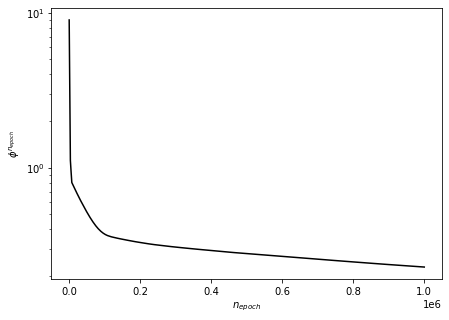

In [82]:
# poissonSolver.plot_solution();
NeumannSolver.plot_loss_history();

In [83]:
def get_exact_solution(x, y):
    const = 1./(1.+np.pi*np.pi)
    return const * (np.cos(np.pi * x) - np.cos(np.pi * y))

Text(0.5, 0.92, 'Spatial Error')

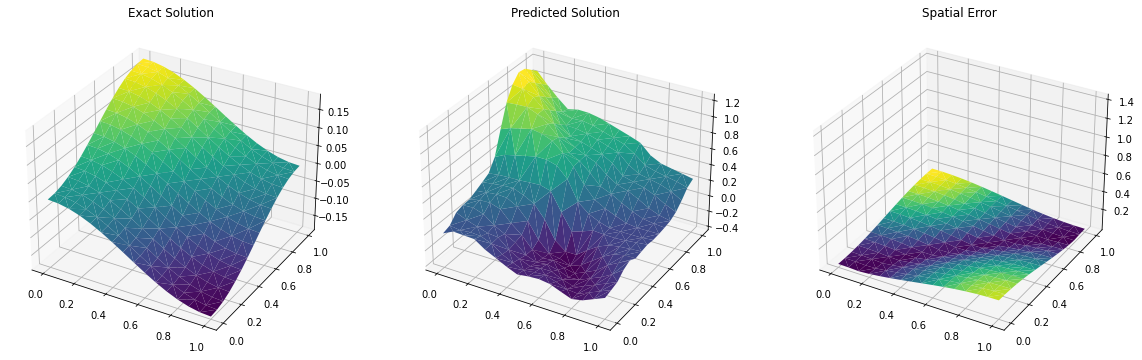

In [84]:
x = p[:,0]
y = p[:,1]
u_exact = get_exact_solution(x,y)
u_pred = NeumannSolver.get_upred(p[:,0], p[:,1])
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(p[:,0], p[:,1], u_exact.flatten(), triangles=s, cmap=plt.cm.viridis)
ax1.set_title("Exact Solution")

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(p[:,0], p[:,1], u_pred.flatten(), triangles=s, cmap=plt.cm.viridis)
ax2.set_title("Predicted Solution")

error = np.abs(u_pred - u_exact)
# error = np.linalg.norm(u_pred - u_exact, np.inf)
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(p[:,0], p[:,1], error.flatten(), triangles=s, cmap=plt.cm.viridis)
ax3.set_title("Spatial Error")

In [85]:
np.linalg.norm(error)

117.8068319832722